In [144]:
import warnings
warnings.filterwarnings('ignore')

import shap
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from imblearn.combine import SMOTEENN, SMOTETomek
from matplotlib.colors import LinearSegmentedColormap
from sklearn.exceptions import NotFittedError
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
import joblib
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, f1_score,precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [145]:
df = pd.read_csv('../data/framingham.csv')

df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
count,4240.000000,4240.000000,4135.000000,4240.000000,4211.000000,4187.000000,4240.000000,4240.000000,4240.000000,4190.000000,4240.000000,4240.000000,4221.000000,4239.000000,3852.000000,4240.000000
mean,0.429245,49.580189,1.979444,0.494104,9.005937,0.029615,0.005896,0.310613,0.025708,236.699523,132.354599,82.897759,25.800801,75.878981,81.963655,0.151887
std,0.495027,8.572942,1.019791,0.500024,11.922462,0.169544,0.076569,0.462799,0.158280,44.591284,22.033300,11.910394,4.079840,12.025348,23.954335,0.358953
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [146]:
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
CHD                  0
dtype: int64

In [147]:
df["glucose"].fillna((df["glucose"].mode())[0], inplace=True)
df.dropna(inplace=True)
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
CHD                0
dtype: int64

In [149]:
print("Original max values:")
print(df['totChol'].max())
print(df['cigsPerDay'].max())

for column in ['totChol', 'sysBP','cigsPerDay']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

print("\nMax values after IQR treatment:")
print(df['totChol'].max())
print(df['cigsPerDay'].max())

Original max values:
600.0
70.0

Max values after IQR treatment:
348.5
50.0


In [150]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CHD
count,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000
mean,0.433191,49.473803,1.982452,0.491101,8.993231,0.029331,0.005515,0.309601,0.025320,236.207069,131.754700,82.865756,25.773387,75.873903,81.284282,0.149160
std,0.495579,8.532381,1.020695,0.499983,11.798233,0.168753,0.074068,0.462387,0.157114,42.603213,20.468186,11.881708,4.079551,12.086113,22.968611,0.356291
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.500000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.060000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,77.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.500000,89.500000,27.990000,83.000000,85.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,50.000000,1.000000,1.000000,1.000000,1.000000,348.500000,183.250000,142.500000,56.800000,143.000000,394.000000,1.000000


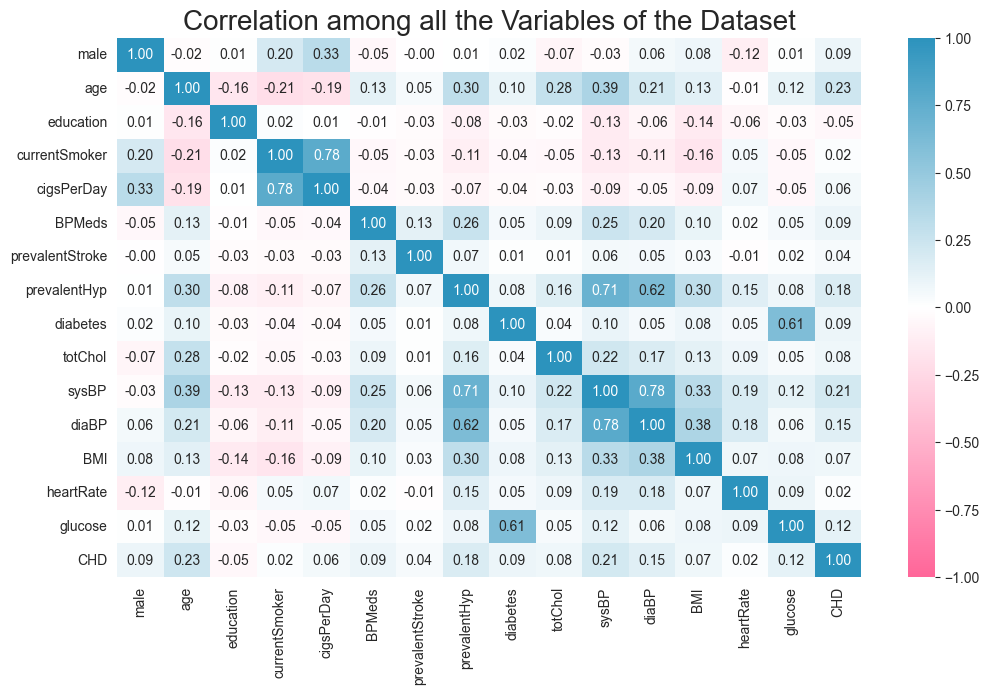

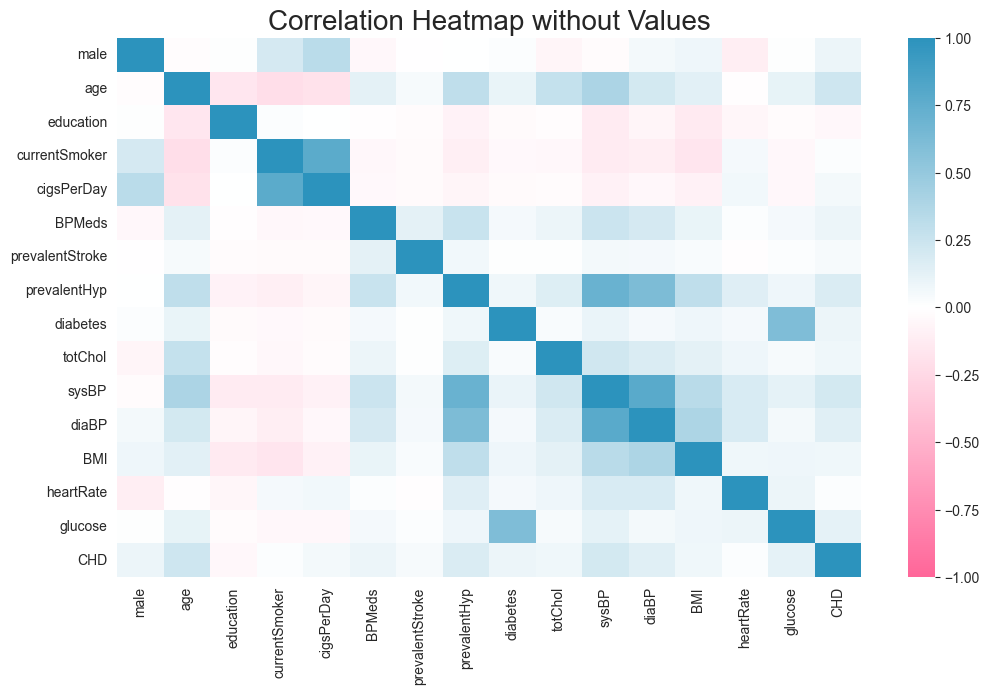

In [151]:
colors = [(1, 0.4, 0.6), (1, 1, 1),(0.174, 0.576, 0.741) ]
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

cor = df.corr()
plt.figure(figsize=(12, 7), facecolor='w')
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1)
plt.title("Correlation among all the Variables of the Dataset", size=20)
plt.show()

plt.figure(figsize=(12, 7), facecolor='w')
sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, annot=False, cmap=cmap, vmin=-1, vmax=1)
plt.title("Correlation Heatmap without Values", size=20)
plt.show()

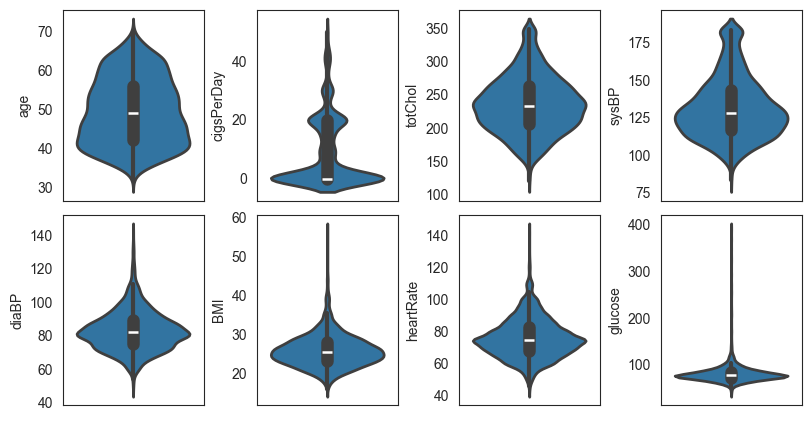

In [154]:
numeric_features = ['age','cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
num_plots = len(numeric_features)
total_cols = 4
total_rows = num_plots // total_cols + 1
color = ['m', 'g', 'b', 'r', 'y', 'v', 'o']
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(2 * total_cols, 2 * total_rows), facecolor='w', constrained_layout=True)

for i, var in enumerate(numeric_features):
    row = i // total_cols
    pos = i % total_cols
    plot = sns.violinplot(y=var, data=df, ax=axs[row][pos], linewidth=2)

for i in range(num_plots, total_rows * total_cols):
    row = i // total_cols
    pos = i % total_cols
    fig.delaxes(axs[row][pos])

plt.show()

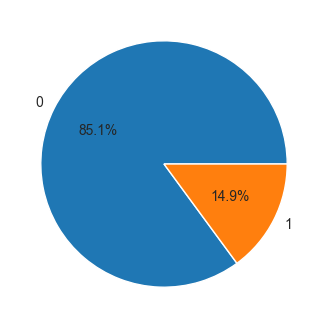

In [155]:
plt.figure(figsize=(5, 4), facecolor='w')
labels=[0,1]
plt.pie(df["CHD"].value_counts(),autopct="%1.1f%%",labels=labels)
plt.show()

In [157]:
from imblearn.over_sampling import SMOTE

X = df.drop(['CHD'], axis=1)
y = df['CHD']

smote_enn = SMOTEENN(random_state=40)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Oversampling rate
original_positives = df['CHD'].value_counts()[1]
resampled_positives = y_resampled.value_counts()[1]
oversampling_rate = ((resampled_positives - original_positives) / original_positives) * 100
print(f"Oversampling rate: {oversampling_rate:.2f}%")

smote = SMOTE(k_neighbors=3, random_state=40)
smote_tomek = SMOTETomek(smote=smote, random_state=40)
X_resampled, y_resampled = smote_tomek.fit_resample(X_resampled, y_resampled)

train_x, test_x, train_y, test_y = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

print(train_x.shape)
print(len(train_x))
print(test_x.shape)
print(len(test_y))

Oversampling rate: 430.42%
(4418, 15)
4418
(1894, 15)
1894


In [168]:
X_df = pd.DataFrame(X_resampled, columns=X.columns)
X_df.describe().round(3)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000,6312.000
mean,0.329,50.061,1.957,0.420,8.976,0.037,0.002,0.284,0.025,238.027,133.444,83.495,25.881,75.711,83.265
std,0.470,8.332,0.932,0.494,11.610,0.163,0.042,0.451,0.157,43.058,21.042,12.051,3.741,11.516,28.209
min,0.000,32.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,124.000,83.500,48.000,15.960,44.000,40.000
25%,0.000,43.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,206.590,118.000,75.000,23.399,67.772,73.000
50%,0.000,50.000,1.989,0.000,1.239,0.000,0.000,0.000,0.000,235.820,129.480,82.000,25.483,75.000,77.000
75%,1.000,57.000,2.664,1.000,20.000,0.000,0.000,1.000,0.000,266.000,145.850,90.000,27.860,82.224,85.895
max,1.000,70.000,4.000,1.000,50.000,1.000,1.000,1.000,1.000,348.500,183.250,142.500,56.800,130.000,394.000


In [180]:
print(X_df['education'].round().astype(int).value_counts())
print(X_df['education'].round().astype(int).value_counts(normalize=True) * 100)

education
1    2524
2    2082
3    1146
4     560
Name: count, dtype: int64
education
1    39.987326
2    32.984791
3    18.155894
4     8.871990
Name: proportion, dtype: float64


In [167]:
train_df = pd.DataFrame(train_x, columns=X.columns)
train_df.describe().round(3)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000,4418.000
mean,0.332,49.994,1.965,0.421,9.037,0.037,0.002,0.285,0.023,237.366,133.508,83.443,25.838,75.631,82.759
std,0.471,8.331,0.940,0.494,11.636,0.165,0.040,0.451,0.149,42.568,21.171,12.095,3.696,11.482,26.409
min,0.000,32.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,128.467,83.500,48.000,16.690,44.000,40.000
25%,0.000,43.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,206.322,118.000,75.000,23.370,67.636,73.000
50%,0.000,50.000,1.986,0.000,1.270,0.000,0.000,0.000,0.000,235.000,129.265,82.000,25.467,75.000,77.000
75%,1.000,57.000,2.709,1.000,20.000,0.000,0.000,1.000,0.000,265.000,146.000,90.000,27.776,82.070,85.715
max,1.000,70.000,4.000,1.000,50.000,1.000,1.000,1.000,1.000,348.500,183.250,142.500,56.800,130.000,394.000


In [179]:
print(train_df['education'].round().astype(int).value_counts())
print(train_df['education'].round().astype(int).value_counts(normalize=True) * 100)

education
1    1765
2    1435
3     814
4     404
Name: count, dtype: int64
education
1    39.950204
2    32.480761
3    18.424627
4     9.144409
Name: proportion, dtype: float64


In [166]:
test_df = pd.DataFrame(test_x, columns=X.columns)
test_df.describe().round(2)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00,1894.00
mean,0.32,50.22,1.94,0.42,8.83,0.04,0.00,0.28,0.03,239.57,133.30,83.62,25.98,75.90,84.45
std,0.47,8.33,0.91,0.49,11.55,0.16,0.05,0.45,0.17,44.15,20.74,11.95,3.84,11.60,31.99
min,0.00,33.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,124.00,85.50,51.00,15.96,45.00,44.00
25%,0.00,43.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,206.83,118.00,75.21,23.47,68.00,73.00
50%,0.00,50.00,2.00,0.00,1.06,0.00,0.00,0.00,0.00,237.62,129.96,82.38,25.53,75.00,77.77
75%,1.00,57.00,2.58,1.00,20.00,0.00,0.00,1.00,0.00,268.00,145.28,90.00,28.04,82.47,86.00
max,1.00,68.00,4.00,1.00,50.00,1.00,1.00,1.00,1.00,348.50,183.25,132.63,55.41,120.00,394.00


In [178]:
print(test_df['education'].round().astype(int).value_counts())
print(test_df['education'].round().astype(int).value_counts(normalize=True) * 100)

education
1    759
2    647
3    332
4    156
Name: count, dtype: int64
education
1    40.073918
2    34.160507
3    17.529039
4     8.236536
Name: proportion, dtype: float64


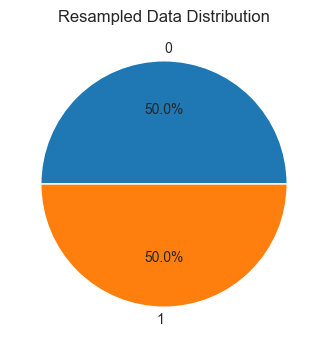

χ^2: 0.0
p value: 1.0


In [74]:
values = y_resampled.value_counts()

plt.figure(figsize=(5, 4), facecolor='w')
labels = ['0', '1']
plt.pie(values, autopct="%1.1f%%", labels=labels)
plt.title('Resampled Data Distribution')
plt.show()

# chi-square test
expected_counts = np.array([sum(values)*0.5, sum(values)*0.5])
chi2, p, dof, expected = chi2_contingency([values, expected_counts])

print(f"χ^2: {chi2}")
print(f"p value: {p}")

            Feature  Score_chi2  Score_mi    Score_f  Total_Score
10            sysBP   2239.8640    0.1569   785.6977    2789.9778
1               age   1400.8443    0.1248  1307.6210    2316.2789
9           totChol   1139.4147    0.0922   154.4422    1247.5980
11            diaBP    579.4012    0.1037   357.1446     829.4854
14          glucose    725.8740    0.1119    87.8243     787.4405
4        cigsPerDay    479.3227    0.0540    32.2202     501.9200
7      prevalentHyp    206.7459    0.0398   309.1471     423.1808
5            BPMeds     84.6940    0.0385   119.3371     168.2607
12              BMI     46.3239    0.0345    89.3732     108.9128
8          diabetes     43.5027    0.0050    44.9533      74.9740
2         education     21.4217    0.0531    48.1092      55.1407
0              male      8.3427    0.0000    12.5155      17.1035
3     currentSmoker      3.3128    0.0036     5.7220       7.3211
13        heartRate      2.2577    0.0863     1.2954       3.2335
6   preval

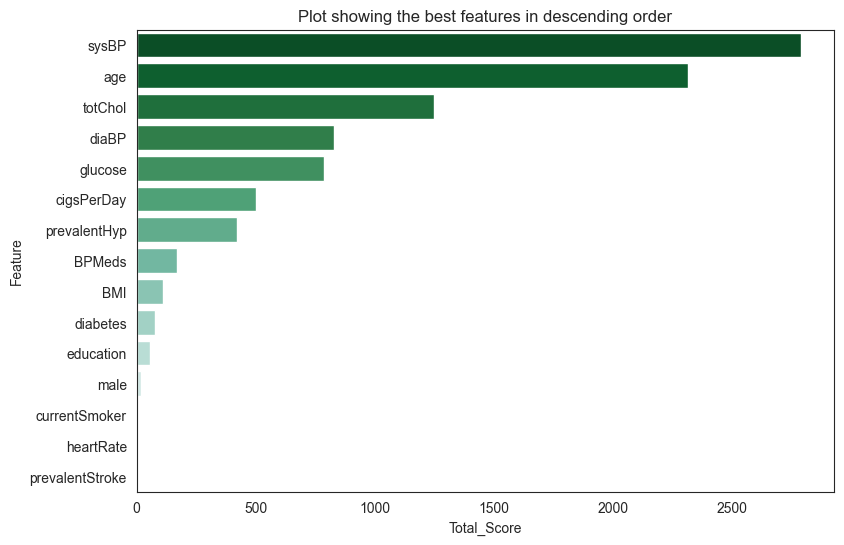

['sysBP', 'age', 'totChol', 'diaBP', 'glucose', 'cigsPerDay', 'prevalentHyp', 'BPMeds', 'BMI', 'diabetes']


['minmax_scaler.pkl']

In [228]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
feature_columns = train_x.columns.tolist()

best_chi2 = SelectKBest(score_func=chi2, k=len(feature_columns))
fit_chi2 = best_chi2.fit(train_x, train_y)
scores_chi2 = pd.DataFrame({'Feature': feature_columns, 'Score_chi2': fit_chi2.scores_})

best_mi = SelectKBest(score_func=mutual_info_classif, k=len(feature_columns))
fit_mi = best_mi.fit(train_x, train_y)
scores_mi = pd.DataFrame({'Feature': feature_columns, 'Score_mi': fit_mi.scores_})

best_f = SelectKBest(score_func=f_classif, k=len(feature_columns))
fit_f = best_f.fit(train_x, train_y)
scores_f = pd.DataFrame({'Feature': feature_columns, 'Score_f': fit_f.scores_})

all_scores = pd.merge(scores_chi2, scores_mi, on='Feature')
all_scores = pd.merge(all_scores, scores_f, on='Feature')

all_scores['Total_Score'] = all_scores['Score_chi2'] + all_scores['Score_mi'] * 0.8 + all_scores['Score_f'] * 0.7
all_scores = all_scores.sort_values(by='Total_Score', ascending=False)

all_scores = all_scores.round(4)
print(all_scores)
all_scores.to_excel('Feature_screening.xlsx', index=False)

plt.figure(figsize=(9, 6), facecolor='w')
sns.barplot(x='Total_Score', y='Feature', data=all_scores, palette='BuGn_r')
plt.title("Plot showing the best features in descending order", size=12)
plt.show()

features = all_scores["Feature"].tolist()[:10]
print(features)

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x[features])
test_x = scaler.transform(test_x[features])

joblib.dump(scaler,'minmax_scaler.pkl')

In [120]:
m1 = 'LogisticRegression'
lr = LogisticRegression(random_state=1, max_iter=20)

lr.max_iter = 20
lr.fit(train_x, train_y)
lr_predict = lr.predict(test_x)

lr_conf_matrix = confusion_matrix(test_y, lr_predict)

lr_acc_score = accuracy_score(test_y, lr_predict)

report = classification_report(test_y, lr_predict, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']

TN, FP, FN, TP = lr_conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print(classification_report(test_y, lr_predict))
print(f"Accuracy of Logistic Regression: {lr_acc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")
joblib.dump(lr, 'lr_model.pkl')

confussion matrix
[[689 230]
 [247 728]]


              precision    recall  f1-score   support

           0       0.74      0.75      0.74       919
           1       0.76      0.75      0.75       975

    accuracy                           0.75      1894
   macro avg       0.75      0.75      0.75      1894
weighted avg       0.75      0.75      0.75      1894

Accuracy of Logistic Regression: 0.7482
Precision: 0.7484
Recall: 0.7482
F1-score: 0.7482
Specificity (Sp): 0.7497
Sensitivity (Sn): 0.7467
Positive Predictive Value (PPV): 0.7599
Negative Predictive Value (NPV): 0.7361


['lr_model.pkl']

In [121]:
m2 = 'KNeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_x, train_y)
knn_predict = knn.predict(test_x)
knn_conf_matrix = confusion_matrix(test_y, knn_predict)
knn_acc_score = accuracy_score(test_y, knn_predict)

TN, FP, FN, TP = knn_conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print(classification_report(test_y, knn_predict))
print(f"Accuracy of k-NN Classification: {knn_acc_score:.4f}")

report = classification_report(test_y, knn_predict, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")
joblib.dump(knn, 'knn_model.pkl')

confussion matrix
[[759 160]
 [ 85 890]]


              precision    recall  f1-score   support

           0       0.90      0.83      0.86       919
           1       0.85      0.91      0.88       975

    accuracy                           0.87      1894
   macro avg       0.87      0.87      0.87      1894
weighted avg       0.87      0.87      0.87      1894

Accuracy of k-NN Classification: 0.8706
Precision: 0.8727
Recall: 0.8706
F1-score: 0.8703
Specificity (Sp): 0.8259
Sensitivity (Sn): 0.9128
Positive Predictive Value (PPV): 0.8476
Negative Predictive Value (NPV): 0.8993


['knn_model.pkl']

In [79]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=200, random_state=0, max_depth=12)
rf.fit(train_x, train_y)
rf_predicted = rf.predict(test_x)
rf_conf_matrix = confusion_matrix(test_y, rf_predicted)
rf_acc_score = accuracy_score(test_y, rf_predicted)

TN, FP, FN, TP = rf_conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print(classification_report(test_y, rf_predicted))

print(f"Accuracy of Random Forest: {rf_acc_score:.4f}")
report = classification_report(test_y, rf_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")

confussion matrix
[[795 124]
 [109 866]]


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       919
           1       0.87      0.89      0.88       975

    accuracy                           0.88      1894
   macro avg       0.88      0.88      0.88      1894
weighted avg       0.88      0.88      0.88      1894

Accuracy of Random Forest: 0.8770
Precision: 0.8770
Recall: 0.8770
F1-score: 0.8769
Specificity (Sp): 0.8651
Sensitivity (Sn): 0.8882
Positive Predictive Value (PPV): 0.8747
Negative Predictive Value (NPV): 0.8794


In [122]:
m4 = 'DecisionTreeClassifier'
for max_depth in range(1,30):
     dt = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=max_depth)
     dt.fit(train_x, train_y)
dt_predicted = dt.predict(test_x)
dt_conf_matrix = confusion_matrix(test_y, dt_predicted)
dt_acc_score = accuracy_score(test_y, dt_predicted)

TN, FP, FN, TP = dt_conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print(classification_report(test_y, dt_predicted))

print(f"Accuracy of DecisionTreeClassifier: {dt_acc_score:.4f}")
report = classification_report(test_y, dt_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")
joblib.dump(dt, 'dt_model.pkl')

confussion matrix
[[772 147]
 [158 817]]


              precision    recall  f1-score   support

           0       0.83      0.84      0.84       919
           1       0.85      0.84      0.84       975

    accuracy                           0.84      1894
   macro avg       0.84      0.84      0.84      1894
weighted avg       0.84      0.84      0.84      1894

Accuracy of DecisionTreeClassifier: 0.8390
Precision: 0.8391
Recall: 0.8390
F1-score: 0.8390
Specificity (Sp): 0.8400
Sensitivity (Sn): 0.8379
Positive Predictive Value (PPV): 0.8475
Negative Predictive Value (NPV): 0.8301


['dt_model.pkl']

In [81]:
m5 = 'Gradient Boosting Classifier'

gvc = GradientBoostingClassifier()
gvc.fit(train_x, train_y)
gvc_predicted = gvc.predict(test_x)
gvc_conf_matrix = confusion_matrix(test_y, gvc_predicted)
gvc_acc_score = accuracy_score(test_y, gvc_predicted)

TN, FP, FN, TP = gvc_conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

report = classification_report(test_y, gvc_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']

print("confussion matrix")
print(gvc_conf_matrix)
print("\n")
print(f"Accuracy of Gradient Boosting Classifier: {gvc_acc_score:.4f}")
print(classification_report(test_y, gvc_predicted))
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")

confussion matrix
[[732 187]
 [201 774]]


Accuracy of Gradient Boosting Classifier: 0.7951
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       919
           1       0.81      0.79      0.80       975

    accuracy                           0.80      1894
   macro avg       0.79      0.80      0.80      1894
weighted avg       0.80      0.80      0.80      1894

Precision: 0.7953
Recall: 0.7951
F1-score: 0.7952
Specificity (Sp): 0.7965
Sensitivity (Sn): 0.7938
Positive Predictive Value (PPV): 0.8054
Negative Predictive Value (NPV): 0.7846


In [123]:
m6 = 'Support Vector Machine Classifier'

svm = SVC(C=1, probability=True, random_state=0)
svm.fit(train_x, train_y)
svm_predicted = svm.predict(test_x)
svm_conf_matrix = confusion_matrix(test_y, svm_predicted)
svm_acc_score = accuracy_score(test_y, svm_predicted)

TN, FP, FN, TP = svm_conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(svm_conf_matrix)
print("\n")
print(classification_report(test_y, svm_predicted))

print(f"Accuracy of Support Vector Machine: {svm_acc_score:.4f}")
report = classification_report(test_y, svm_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")
joblib.dump(svm, 'svm_model.pkl')

confussion matrix
[[681 238]
 [209 766]]


              precision    recall  f1-score   support

           0       0.77      0.74      0.75       919
           1       0.76      0.79      0.77       975

    accuracy                           0.76      1894
   macro avg       0.76      0.76      0.76      1894
weighted avg       0.76      0.76      0.76      1894

Accuracy of Support Vector Machine: 0.7640
Precision: 0.7640
Recall: 0.7640
F1-score: 0.7638
Specificity (Sp): 0.7410
Sensitivity (Sn): 0.7856
Positive Predictive Value (PPV): 0.7629
Negative Predictive Value (NPV): 0.7652


['svm_model.pkl']

In [124]:
m7 = 'Naive Bayes Classifier'
nb = GaussianNB()
nb.fit(train_x, train_y)
nb_predicted = nb.predict(test_x)
nb_conf_matrix = confusion_matrix(test_y, nb_predicted)
nb_acc_score = accuracy_score(test_y, nb_predicted)

TN, FP, FN, TP = nb_conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print(classification_report(test_y, nb_predicted))

print(f"Accuracy of Naive Bayes: {nb_acc_score:.4f}")
report = classification_report(test_y, nb_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")
joblib.dump(nb, 'nb_model.pkl')

confussion matrix
[[821  98]
 [540 435]]


              precision    recall  f1-score   support

           0       0.60      0.89      0.72       919
           1       0.82      0.45      0.58       975

    accuracy                           0.66      1894
   macro avg       0.71      0.67      0.65      1894
weighted avg       0.71      0.66      0.65      1894

Accuracy of Naive Bayes: 0.6631
Precision: 0.7128
Recall: 0.6631
F1-score: 0.6464
Specificity (Sp): 0.8934
Sensitivity (Sn): 0.4462
Positive Predictive Value (PPV): 0.8161
Negative Predictive Value (NPV): 0.6032


['nb_model.pkl']

In [84]:
max_features = ['log2','sqrt']
n_estimators = [500, 1000, 1500, 2000]
max_depth = [10, 20, 30, 40, None]
min_samples_split = [5, 10, 15]
min_samples_leaf = [2, 4, 6]
bootstrap = [True]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
print(random_grid)

def log_loss_score(estimator, X, y):
    proba = estimator.predict_proba(X)
    return log_loss(y, proba)

rf = RandomForestClassifier(random_state=6)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    cv=10,
    scoring={
        'accuracy': 'accuracy',
        'log_loss': log_loss_score
    },
    refit='accuracy',
    verbose=2,
    random_state=7,
    n_jobs=-1
)

rf_random.fit(train_x, train_y)

{'n_estimators': [500, 1000, 1500, 2000], 'max_features': ['log2', 'sqrt'], 'max_depth': [10, 20, 30, 40, None], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [2, 4, 6], 'bootstrap': [True]}
Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=6),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [500, 1000, 1500,
                                                         2000]},
                   random_state=7, refit='accuracy',
                   scoring={'accuracy': 'accuracy',
                            'log_loss': <function log_loss_score at 0x000001A0CA3FCF40>},
                   verbose=2)

In [85]:
rf_hyper = rf_random.best_estimator_
rf_hyper.fit(train_x,train_y)

best_rf_params = rf_random.best_params_

joblib.dump(rf_hyper, 'rf_model.pkl')

rf_predicted = rf_hyper.predict(test_x)

conf_matrix = confusion_matrix(test_y, rf_predicted)
TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(conf_matrix)

rf_acc_score = accuracy_score(test_y, rf_predicted)
print(classification_report(test_y, rf_predicted))

print(f"Accuracy of Hyper-tuned Random Forest Classifier: {rf_acc_score:.4f}")
report = classification_report(test_y, rf_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")

confussion matrix
[[823  96]
 [103 872]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       919
           1       0.90      0.89      0.90       975

    accuracy                           0.89      1894
   macro avg       0.89      0.89      0.89      1894
weighted avg       0.89      0.89      0.89      1894

Accuracy of Hyper-tuned Random Forest Classifier: 0.8949
Precision: 0.8950
Recall: 0.8949
F1-score: 0.8949
Specificity (Sp): 0.8955
Sensitivity (Sn): 0.8944
Positive Predictive Value (PPV): 0.9008
Negative Predictive Value (NPV): 0.8888


In [86]:
n_estimators = [int(i) for i in np.linspace(start=100,stop=500,num=10)]
max_features = ['log2','sqrt']
max_depth = [int(i) for i in np.linspace(5, 30, num=10)]
max_depth.append(None)
min_samples_split=[5, 15, 25]
min_samples_leaf = [3,5,7]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': [0.01, 0.05, 0.1]}

gb=GradientBoostingClassifier(random_state=0)
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=random_grid,
                               n_iter=100,
                               scoring='f1',
                               cv=10, verbose=2, random_state=0, n_jobs=-1,
                               return_train_score=True)

gb_random.fit(train_x,train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 7, 10, 13, 16, 18, 21,
                                                      24, 27, 30, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [3, 5, 7],
                                        'min_samples_split': [5, 15, 25],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   random_state=0, return_train_score=True, scoring='f1',
                   verbose=2)

In [87]:
gbc_hyper = gb_random.best_estimator_
gbc_hyper.fit(train_x,train_y)

gbc_predicted = gbc_hyper.predict(test_x)

conf_matrix = confusion_matrix(test_y, gbc_predicted)
TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(conf_matrix)

gbc_acc_score = accuracy_score(test_y, gbc_predicted)
print(classification_report(test_y, gbc_predicted))

joblib.dump(gbc_hyper, 'gbc_model.pkl')

print(f"Accuracy of Hyper-tuned Gradient Boosting Classifier: {gbc_acc_score:.4f}")
report = classification_report(test_y, gbc_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")

confussion matrix
[[864  55]
 [ 54 921]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       919
           1       0.94      0.94      0.94       975

    accuracy                           0.94      1894
   macro avg       0.94      0.94      0.94      1894
weighted avg       0.94      0.94      0.94      1894

Accuracy of Hyper-tuned Gradient Boosting Classifier: 0.9424
Precision: 0.9424
Recall: 0.9424
F1-score: 0.9424
Specificity (Sp): 0.9402
Sensitivity (Sn): 0.9446
Positive Predictive Value (PPV): 0.9436
Negative Predictive Value (NPV): 0.9412


In [263]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_test = lgb.Dataset(test_x, label=test_y, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'max_depth': -1,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'subsample': 0.8,
    'subsample_freq': 0,
    'verbose': 0
}

num_round = 100
lgbm = lgb.train(
    params,
    lgb_train,
    num_round,
    valid_sets=[lgb_train, lgb_test]
)

lgbm_pred_proba = lgbm.predict(test_x)
lgbm_pred = np.round(lgbm_pred_proba)

conf_matrix = confusion_matrix(test_y, lgbm_pred)

train_pred = lgbm.predict(train_x)
train_pred = np.round(train_pred)
train_acc = accuracy_score(train_y, train_pred)

val_acc = accuracy_score(test_y, lgbm_pred)

lgbm_acc_score = accuracy_score(test_y, lgbm_pred)

TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(conf_matrix)
print(classification_report(test_y, lgbm_pred))

print(f"Accuracy of Hyper - tuned Light Classifier: {lgbm_acc_score :.4f}")
report = classification_report(test_y, lgbm_pred, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")
joblib.dump(lgbm, 'lgbm_model.pkl')

confussion matrix
[[824  95]
 [122 853]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       919
           1       0.90      0.87      0.89       975

    accuracy                           0.89      1894
   macro avg       0.89      0.89      0.89      1894
weighted avg       0.89      0.89      0.89      1894

Accuracy of Hyper - tuned Light Classifier: 0.8854
Precision: 0.8858
Recall: 0.8854
F1-score: 0.8855
Specificity (Sp): 0.8966
Sensitivity (Sn): 0.8749
Positive Predictive Value (PPV): 0.8998
Negative Predictive Value (NPV): 0.8710


['lgbm_model.pkl']

In [106]:
import catboost as cb

params = {
    'learning_rate': 0.01,
    'depth': 16,
    'iterations': 100,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'random_state': 42,
    'use_best_model': True,
    'early_stopping_rounds': 10
}

cbm = cb.CatBoostClassifier(**params)

cbm.fit(train_x, train_y,
          eval_set=(test_x, test_y),
          cat_features=[],
          use_best_model=True,
          verbose=0)

cbm_pred = cbm.predict(test_x)
conf_matrix = confusion_matrix(test_y, cbm_pred)

train_pred = cbm.predict(train_x)
train_acc = accuracy_score(train_y, train_pred)

val_acc = accuracy_score(test_y, cbm_pred)

cbm_acc_score = accuracy_score(test_y, cbm_pred)

TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(conf_matrix)

print(classification_report(test_y, cbm_pred))

print(f"Accuracy of CatBoost Classifier: {cbm_acc_score :.4f}")
report = classification_report(test_y, cbm_pred, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")
joblib.dump(cbm, 'catboost_model.pkl')

confussion matrix
[[738 181]
 [127 848]]
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       919
           1       0.82      0.87      0.85       975

    accuracy                           0.84      1894
   macro avg       0.84      0.84      0.84      1894
weighted avg       0.84      0.84      0.84      1894

Accuracy of CatBoost Classifier: 0.8374
Precision: 0.8382
Recall: 0.8374
F1-score: 0.8371
Specificity (Sp): 0.8030
Sensitivity (Sn): 0.8697
Positive Predictive Value (PPV): 0.8241
Negative Predictive Value (NPV): 0.8532


['catboost_model.pkl']

In [88]:
params_xgb = {
    'learning_rate': 0.1,
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'max_leaves': 127,
    'verbosity': 1,
    'seed': 42,
    'nthread': -1,
    'colsample_bytree': 0.6,
    'subsample': 0.8,
    'eval_metric': 'logloss'
}

model_xgb = xgb.XGBClassifier(**params_xgb)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
}

grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_log_loss',
    cv=10,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(train_x, train_y)

print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best Log Loss score:  0.240606478317574


In [89]:
from sklearn.metrics import classification_report
xgb_hyper = grid_search.best_estimator_
xgb_hyper.fit(train_x, train_y)

joblib.dump(xgb_hyper, 'xgb_model.pkl')

xgb_predicted = xgb_hyper.predict(test_x)
conf_matrix = confusion_matrix(test_y,xgb_predicted)
xgb_acc_score = accuracy_score(test_y, xgb_predicted)

TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(conf_matrix)
print(classification_report(test_y,xgb_predicted))

print(f"Accuracy of Hyper - tuned XGBoost Classifier: {xgb_acc_score :.4f}")
report = classification_report(test_y, xgb_predicted, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result= report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")

confussion matrix
[[849  70]
 [ 75 900]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       919
           1       0.93      0.92      0.93       975

    accuracy                           0.92      1894
   macro avg       0.92      0.92      0.92      1894
weighted avg       0.92      0.92      0.92      1894

Accuracy of Hyper - tuned XGBoost Classifier: 0.9234
Precision: 0.9235
Recall: 0.9234
F1-score: 0.9234
Specificity (Sp): 0.9238
Sensitivity (Sn): 0.9231
Positive Predictive Value (PPV): 0.9278
Negative Predictive Value (NPV): 0.9188


In [290]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

lr_score = lr.predict_proba(test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(test_y, lr_score)
lr_auc= auc(fpr_lr, tpr_lr)

knn_score = knn.predict_proba(test_x)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(test_y, knn_score)
knn_auc = auc(fpr_knn, tpr_knn)

rf_score = rf_hyper.predict_proba(test_x)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_y, rf_score)
rf_auc = auc(fpr_rf, tpr_rf)

dt_score = dt.predict_proba(test_x)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(test_y, dt_score)
dt_auc = auc(fpr_dt, tpr_dt)

svm_score = svm.predict_proba(test_x)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(test_y, svm_score)
svm_auc = auc(fpr_svm, tpr_svm)

nb_score = nb.predict_proba(test_x)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(test_y, nb_score)
nb_auc = auc(fpr_nb, tpr_nb)

gbc_score = gbc_hyper.predict_proba(test_x)[:, 1]
fpr_gbc, tpr_gbc, _ = roc_curve(test_y, gbc_score)
gbc_auc = auc(fpr_gbc, tpr_gbc)

lgbm_score = lgbm.predict(test_x)
fpr_lgbm, tpr_lgbm, thresholds = roc_curve(test_y, lgbm_score)
lgbm_auc = auc(fpr_lgbm, tpr_lgbm)

cbm_score = cbm.predict(test_x)
fpr_cbm, tpr_cbm, thresholds = roc_curve(test_y, cbm_score)
cbm_auc = auc(fpr_cbm, tpr_cbm)

xgb_score = xgb_hyper.predict_proba(test_x)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(test_y, xgb_score)
xgb_auc = auc(fpr_xgb, tpr_xgb)

In [94]:
model_ev = pd.DataFrame({'Model': ['LR','KNN','RF','DT','SVM','NB','GBC','LightGBM','CatBoost','XGBoost'],
                         'Accuracy': [lr_acc_score*100, knn_acc_score*100,rf_acc_score*100, dt_acc_score*100,svm_acc_score*100,nb_acc_score*100,gbc_acc_score*100,lgbm_acc_score*100,cbm_acc_score*100,xgb_acc_score*100]})
model_ev = model_ev.sort_values(by='Accuracy', ascending=False)
print(model_ev)

      Model   Accuracy
6       GBC  94.244984
9   XGBoost  92.344245
2        RF  89.493136
7  LightGBM  88.542767
1       KNN  87.064414
3        DT  83.896515
8  CatBoost  83.738120
4       SVM  76.399155
0        LR  74.815206
5        NB  66.314678


In [99]:
from sklearn.metrics import f1_score as calculate_f1_score

base_learners = [
    ("RF", RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, n_estimators=1500, random_state=6)),
    ("XGB", XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=500)),
    ("GBC", GradientBoostingClassifier(max_depth=24,max_features='sqrt', min_samples_leaf=5, min_samples_split=25, n_estimators=500, random_state=0))
]

meta_model = LogisticRegression()

stacking_classifier = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=10)

stacking_classifier.fit(train_x, train_y)

y_pred = stacking_classifier.predict(test_x)

accuracy = accuracy_score(test_y, y_pred)
print(accuracy)

conf_matrix = confusion_matrix(test_y, y_pred)

TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(conf_matrix)

print(classification_report(test_y, y_pred))
y_pred_proba = stacking_classifier.predict_proba(test_x)[:, 1]

meta_learner = stacking_classifier.final_estimator

base_learner_predictions = np.array([learner.predict(train_x) for name, learner in stacking_classifier.named_estimators_.items()]).T

try:
    meta_learner.predict_proba(base_learner_predictions[:1])
except NotFittedError:
    meta_learner.fit(base_learner_predictions, train_y)

explainer = shap.Explainer(meta_learner.predict_proba, base_learner_predictions)
shap_values = explainer(base_learner_predictions)

auc = roc_auc_score(test_y, y_pred_proba)
print(f"AUC: {auc:.4f}")

f1 = calculate_f1_score(test_y, y_pred)
print(f"F1 Score: {f1:.4f}")

recall = recall_score(test_y, y_pred)
print(f"Recall: {recall:.4f}")

precision = precision_score(test_y, y_pred)
print(f"Precision: {precision:.4f}")
joblib.dump(stacking_classifier, 'stacking_classifier.pkl')
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")

0.9424498416050686
confussion matrix
[[866  53]
 [ 56 919]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       919
           1       0.95      0.94      0.94       975

    accuracy                           0.94      1894
   macro avg       0.94      0.94      0.94      1894
weighted avg       0.94      0.94      0.94      1894

AUC: 0.9773
F1 Score: 0.9440
Recall: 0.9426
Precision: 0.9455
Specificity (Sp): 0.9423
Sensitivity (Sn): 0.9426
Positive Predictive Value (PPV): 0.9455
Negative Predictive Value (NPV): 0.9393


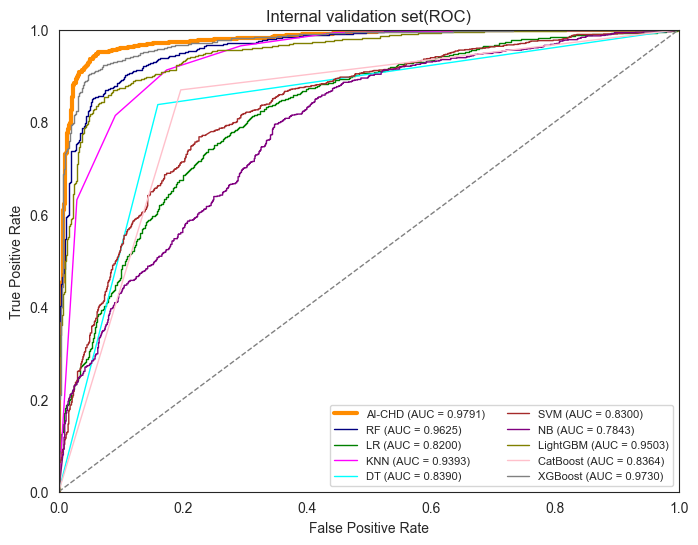

In [291]:
fpr_stacking, tpr_stacking, _ = roc_curve(test_y, y_pred_proba)
auc_stacking = roc_auc_score(test_y, y_pred_proba)

lr_score = lr.predict_proba(test_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(test_y, lr_score)
lr_auc = auc(fpr_lr, tpr_lr)

knn_score = knn.predict_proba(test_x)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(test_y, knn_score)
knn_auc = auc(fpr_knn, tpr_knn)

rf_score = rf_hyper.predict_proba(test_x)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_y, rf_score)
rf_auc = auc(fpr_rf, tpr_rf)

dt_score = dt.predict_proba(test_x)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(test_y, dt_score)
dt_auc = auc(fpr_dt, tpr_dt)

svm_score = svm.predict_proba(test_x)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(test_y, svm_score)
svm_auc = auc(fpr_svm, tpr_svm)

nb_score = nb.predict_proba(test_x)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(test_y, nb_score)
nb_auc = auc(fpr_nb, tpr_nb)

gbc_score = gbc_hyper.predict_proba(test_x)[:, 1]
fpr_gbc, tpr_gbc, _ = roc_curve(test_y, gbc_score)
gbc_auc = auc(fpr_gbc, tpr_gbc)

lgbm_score = lgbm.predict(test_x)
fpr_lgbm, tpr_lgbm, _ = roc_curve(test_y, lgbm_score)
lgbm_auc = auc(fpr_lgbm, tpr_lgbm)

cbm_score = cbm.predict(test_x)
fpr_cbm, tpr_cbm, _ = roc_curve(test_y, cbm_score)
cbm_auc = auc(fpr_cbm, tpr_cbm)

xgb_score = xgb_hyper.predict_proba(test_x)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(test_y, xgb_score)
xgb_auc = auc(fpr_xgb, tpr_xgb)

sns.set_style('white')
plt.figure(figsize=(8, 6), facecolor='w')
plt.title('Internal validation set(ROC)', fontsize=12)

plt.plot(fpr_stacking, tpr_stacking, label=f'AI-CHD (AUC = {auc_stacking:.4f})',
         color='darkorange', linewidth=3)
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {rf_auc:.4f})',
         color='navy', linewidth=1)
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {lr_auc:.4f})',
         color='green', linewidth=1)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {knn_auc:.4f})',
         color='magenta', linewidth=1)
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {dt_auc:.4f})',
         color='cyan', linewidth=1)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {svm_auc:.4f})',
         color='brown', linewidth=1)
plt.plot(fpr_nb, tpr_nb, label=f'NB (AUC = {nb_auc:.4f})',
         color='purple', linewidth=1)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {lgbm_auc:.4f})',
         color='olive', linewidth=1)
plt.plot(fpr_cbm, tpr_cbm, label=f'CatBoost (AUC = {cbm_auc:.4f})',
         color='pink', linewidth=1)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.4f})',
         color='gray', linewidth=1)

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.plot([0, 0], [1, 0], c='.5')
plt.plot([1, 1], c='.5')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.legend(loc='lower right', fontsize=8, ncol=2)
plt.grid(False)

plt.show()

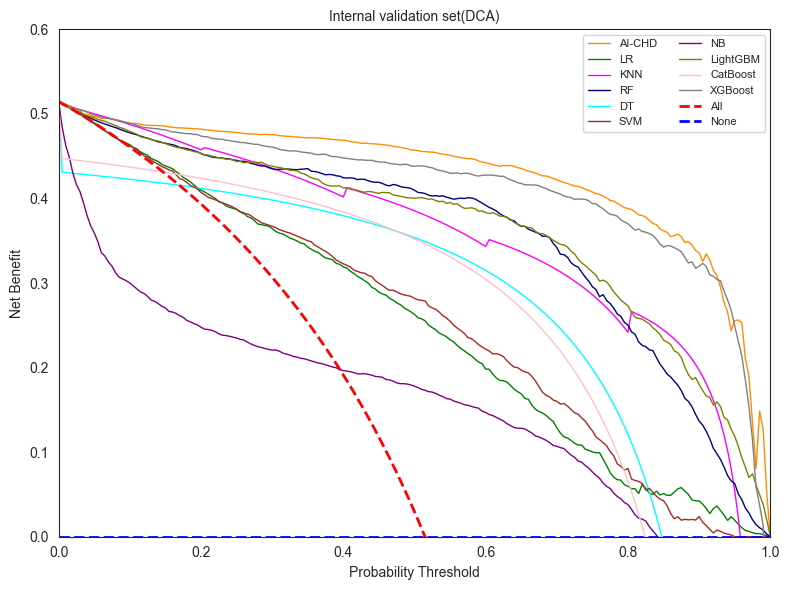

In [278]:
def decision_curve_analysis(y_true, y_proba, thresholds=None, label='Model'):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 201)

    net_benefits = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
        n = len(y_true)
        benefit = (tp / n) - (fp / n) * (t / (1 - t)) if (1 - t) != 0 else 0
        net_benefits.append(benefit)

    p = np.mean(y_true)
    all_positive = [p - (1-p) * (t/(1-t)) if (1-t) != 0 else 0 for t in thresholds]
    all_negative = [0] * len(thresholds)

    return thresholds, net_benefits, all_positive, all_negative

plt.figure(figsize=(8, 6))

thresholds, net_benefits_new, all_positive, all_negative = decision_curve_analysis(
    test_y, y_pred_proba, label='Stacking Model')
_, net_benefits_lr, _, _ = decision_curve_analysis(test_y, lr_score, label='LR Model')
_, net_benefits_knn, _, _ = decision_curve_analysis(test_y, knn_score, label='KNN Model')
_, net_benefits_rf, _, _ = decision_curve_analysis(test_y, rf_score, label='RF Model')
_, net_benefits_dt, _, _ = decision_curve_analysis(test_y, dt_score, label='DT Model')
_, net_benefits_svm, _, _ = decision_curve_analysis(test_y, svm_score, label='SVM Model')
_, net_benefits_nb, _, _ = decision_curve_analysis(test_y, nb_score, label='NB Model')
_, net_benefits_lgbm, _, _ = decision_curve_analysis(test_y, lgbm_score, label='LightGBM Model')
_, net_benefits_cbm, _, _ = decision_curve_analysis(test_y, cbm_score, label='CatBoost Model')
_, net_benefits_xgb, _, _ = decision_curve_analysis(test_y, xgb_score, label='XGBoost Model')

plt.plot(thresholds, net_benefits_new, color='darkorange', lw=1, label='AI-CHD')
plt.plot(thresholds, net_benefits_lr, color='green', lw=1, label='LR')
plt.plot(thresholds, net_benefits_knn, color='magenta', lw=1, label='KNN')
plt.plot(thresholds, net_benefits_rf, color='navy', lw=1, label='RF')
plt.plot(thresholds, net_benefits_dt, color='cyan', lw=1, label='DT')
plt.plot(thresholds, net_benefits_svm, color='brown', lw=1, label='SVM')
plt.plot(thresholds, net_benefits_nb, color='purple', lw=1, label='NB')
plt.plot(thresholds, net_benefits_lgbm, color='olive', lw=1, label='LightGBM')
plt.plot(thresholds, net_benefits_cbm, color='pink', lw=1, label='CatBoost')
plt.plot(thresholds, net_benefits_xgb, color='gray', lw=1, label='XGBoost')

plt.plot(thresholds, all_positive, color='red', linestyle='--', lw=2, label='All')
plt.plot(thresholds, all_negative, color='blue', linestyle='--', lw=2, label='None')

plt.xlabel('Probability Threshold', fontsize=10)
plt.ylabel('Net Benefit', fontsize=10)
plt.title('Internal validation set(DCA)', fontsize=10)
plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.xlim([0, 1])
plt.ylim([0, 0.6])
plt.tight_layout()
plt.show()

In [100]:
from sklearn.metrics import f1_score as calculate_f1_score
base_learner_test_predictions = np.array([learner.predict(test_x) for name, learner in stacking_classifier.named_estimators_.items()]).T

meta_learner_test_predictions = meta_learner.predict_proba(base_learner_test_predictions)[:, 1]

y_pred = meta_learner.predict(base_learner_test_predictions)

accuracy_bootstraps = []
auc_bootstraps = []
f1_bootstraps = []
recall_bootstraps = []
precision_bootstraps = []
ppv_bootstraps = []
npv_bootstraps = []
sn_bootstraps = []
sp_bootstraps = []

n_bootstraps = 1000

for _ in range(n_bootstraps):
    indices = resample(np.arange(len(test_y)), replace=True, n_samples=len(test_y))
    if np.any(indices >= len(test_y)) or np.any(indices < 0):
        continue

    y_true_boot = test_y.iloc[indices]

    y_pred_proba_boot = meta_learner_test_predictions[indices]
    y_pred_boot = y_pred[indices]

    cm = confusion_matrix(y_true_boot, y_pred_boot)
    tn, fp, fn, tp = cm.ravel()

    ppv_boot = tp / (tp + fp) if (tp + fp) != 0 else 0
    ppv_bootstraps.append(ppv_boot)

    npv_boot = tn / (tn + fn) if (tn + fn) != 0 else 0
    npv_bootstraps.append(npv_boot)

    sn_boot = recall_score(y_true_boot, y_pred_boot)
    sn_bootstraps.append(sn_boot)

    sp_boot = tn / (tn + fp) if (tn + fp) != 0 else 0
    sp_bootstraps.append(sp_boot)

    accuracy_boot = accuracy_score(y_true_boot, y_pred_boot)
    auc_boot = roc_auc_score(y_true_boot, y_pred_proba_boot)
    f1_boot = calculate_f1_score(y_true_boot, y_pred_boot)
    recall_boot = recall_score(y_true_boot, y_pred_boot)
    precision_boot = precision_score(y_true_boot, y_pred_boot)

    accuracy_bootstraps.append(accuracy_boot)
    auc_bootstraps.append(auc_boot)
    f1_bootstraps.append(f1_boot)
    recall_bootstraps.append(recall_boot)
    precision_bootstraps.append(precision_boot)

alpha = 0.05
accuracy_ci = np.percentile(accuracy_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
auc_ci = np.percentile(auc_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
f1_ci = np.percentile(f1_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
recall_ci = np.percentile(recall_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
precision_ci = np.percentile(precision_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
ppv_ci = np.percentile(ppv_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
npv_ci = np.percentile(npv_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
sn_ci = np.percentile(sn_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])
sp_ci = np.percentile(sp_bootstraps, [100 * alpha / 2, 100 * (1 - alpha / 2)])

print(f"Accuracy 95% CI: {accuracy_ci}")
print(f"AUC 95% CI: {auc_ci}")
print(f"F1-score 95% CI: {f1_ci}")
print(f"Recall 95% CI: {recall_ci}")
print(f"Precision 95% CI: {precision_ci}")
print(f"PPV 95% CI: {ppv_ci}")
print(f"NPV 95% CI: {npv_ci}")
print(f"Sn 95% CI: {sn_ci}")
print(f"Sp 95% CI: {sp_ci}")

Accuracy 95% CI: [0.91710665 0.93928194]
AUC 95% CI: [0.9409097  0.96060262]
F1-score 95% CI: [0.91891478 0.94175322]
Recall 95% CI: [0.91346927 0.94570295]
Precision 95% CI: [0.91478426 0.94678981]
PPV 95% CI: [0.91478426 0.94678981]
NPV 95% CI: [0.90811588 0.94181034]
Sn 95% CI: [0.91346927 0.94570295]
Sp 95% CI: [0.90974211 0.94335881]


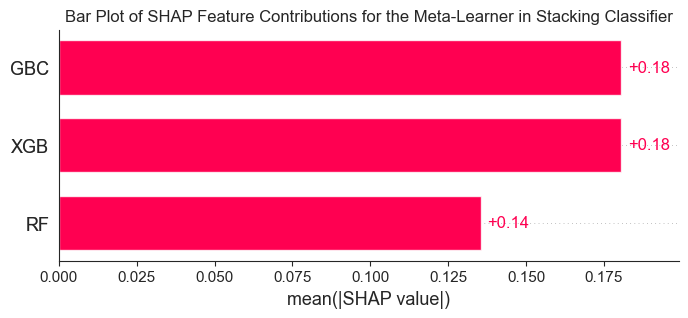

In [101]:
if shap_values.values.size == 0:
    print("SHAP values are empty. Check the calculation process.")
else:
    if len(shap_values.values.shape) != 2:
        shap_values.values = shap_values.values[:, :, 0]

    feature_names = [name for name, _ in base_learners]
    shap_values.feature_names = feature_names

    num_features = shap_values.values.shape[1]
    max_display = min(len(base_learners), num_features)

    plt.figure()
    shap.plots.bar(shap_values, max_display=max_display, show=False)
    plt.title("Bar Plot of SHAP Feature Contributions for the Meta-Learner in Stacking Classifier")
    plt.show()

In [293]:
background = shap.sample(test_x, 100)

explainer_stacking = shap.KernelExplainer(stacking_classifier.predict_proba, background)

shap_values_stacking = explainer_stacking.shap_values(test_x, nsamples=100)
print(shap_values_stacking.shape)

joblib.dump(background, 'background_data.pkl')

if len(shap_values_stacking.shape) == 3:
    shap_values_stacking = shap_values_stacking[:, :, 1]

if len(shap_values_stacking.shape) == 1:
    shap_values_stacking = shap_values_stacking.reshape(-1, 1)

print("Converted SHAP values shape:", shap_values_stacking.shape)

features = ['sysBP', 'age', 'totChol', 'diaBP', 'glucose', 'cigsPerDay', 'prevalentHyp', 'BPMeds', 'BMI', 'diabetes']

test_x_df = pd.DataFrame(test_x, columns=features)

min_samples = min(shap_values_stacking.shape[0], test_x_df.shape[0])
shap_values_trimmed = shap_values_stacking[:min_samples]
test_x_trimmed = test_x_df.iloc[:min_samples]

  0%|          | 0/1894 [00:00<?, ?it/s]

(1894, 10, 2)
Converted SHAP values shape: (1894, 10)


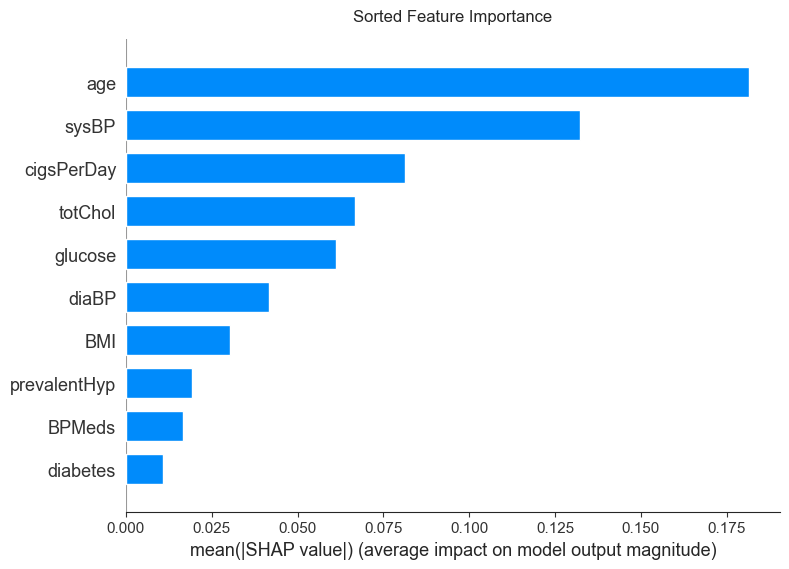

In [294]:
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values_trimmed, test_x_trimmed, feature_names=features, plot_type="bar", show=False)
plt.tight_layout()
plt.title("Sorted Feature Importance", fontsize=12, y=1.02)
plt.show()

<Figure size 500x300 with 0 Axes>

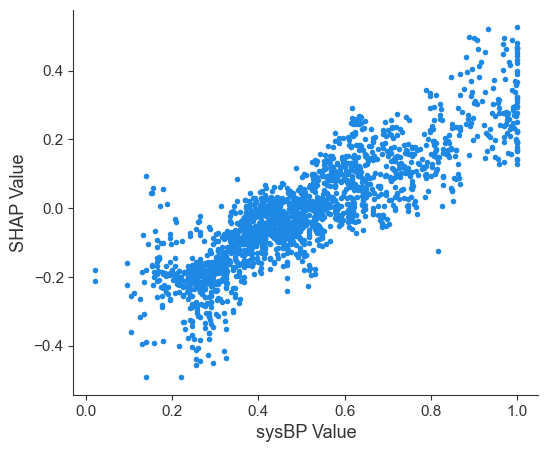

<Figure size 500x300 with 0 Axes>

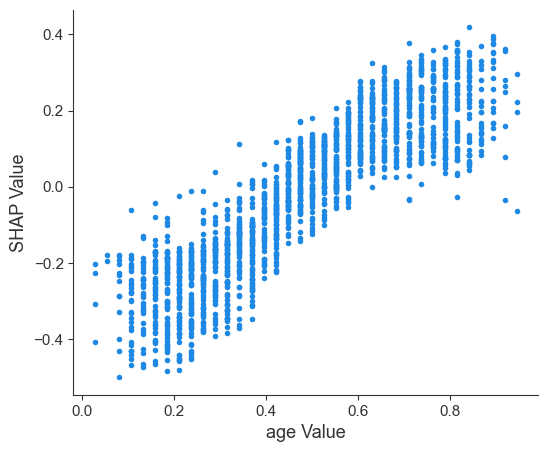

<Figure size 500x300 with 0 Axes>

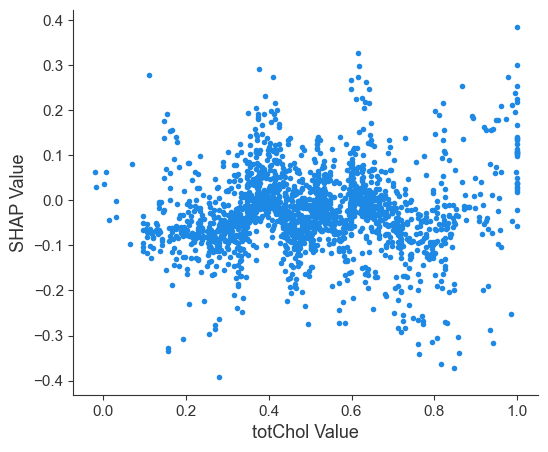

<Figure size 500x300 with 0 Axes>

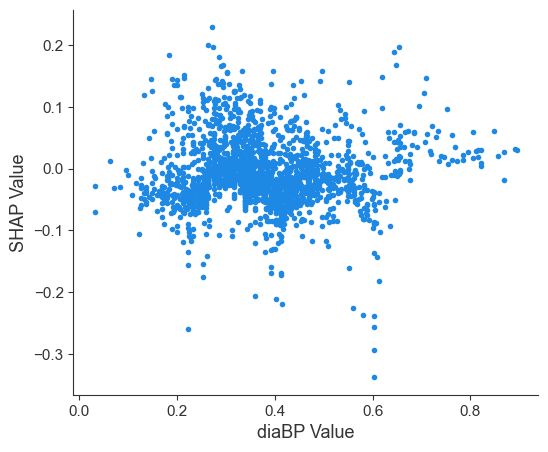

<Figure size 500x300 with 0 Axes>

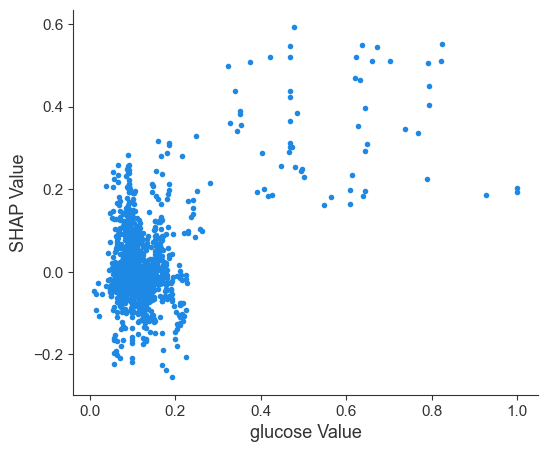

<Figure size 500x300 with 0 Axes>

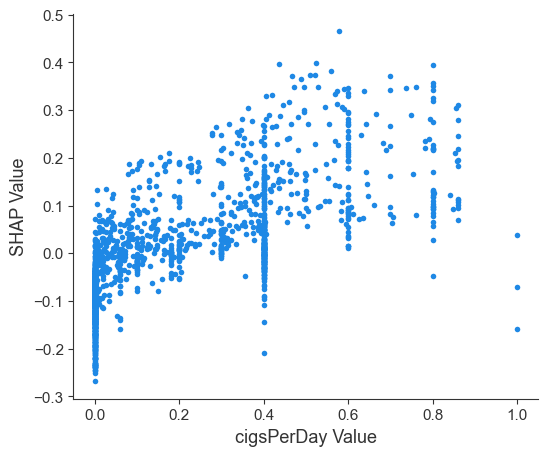

<Figure size 500x300 with 0 Axes>

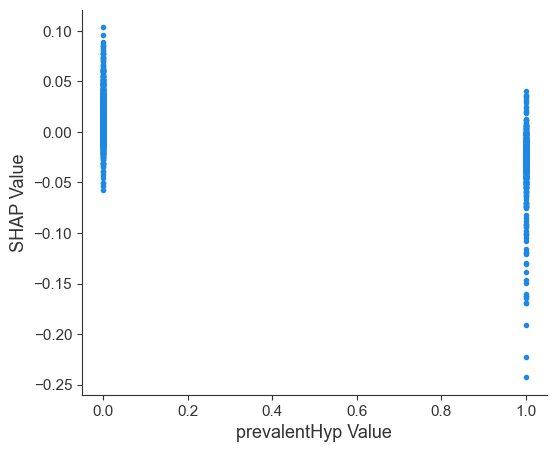

<Figure size 500x300 with 0 Axes>

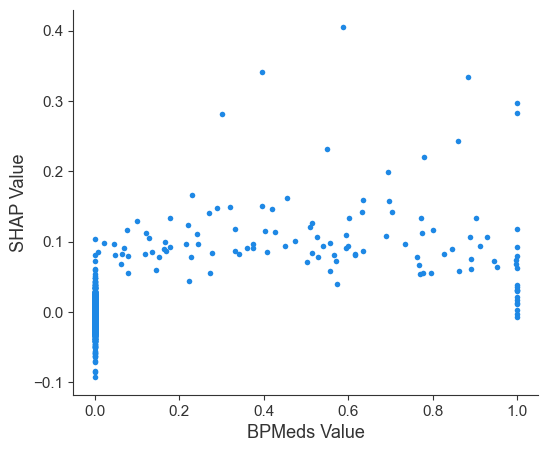

<Figure size 500x300 with 0 Axes>

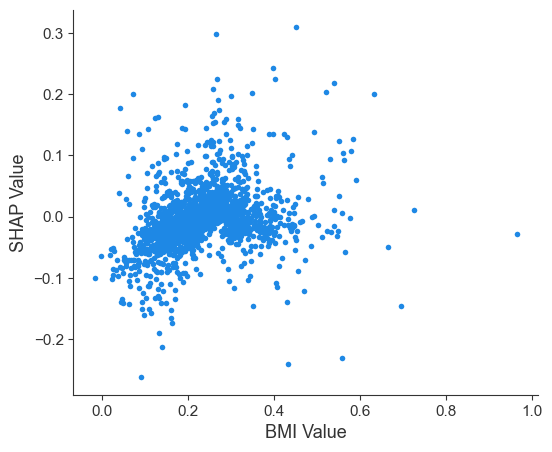

<Figure size 500x300 with 0 Axes>

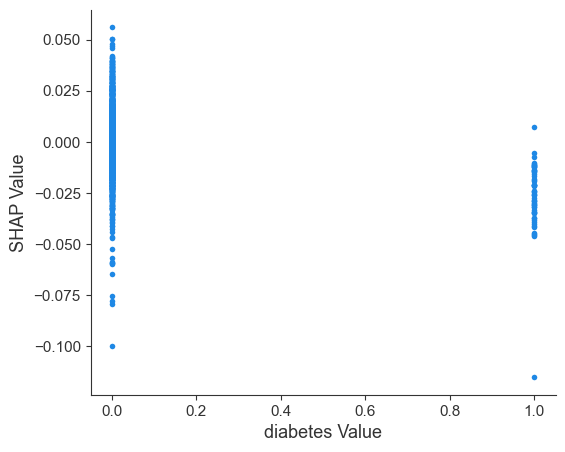

In [133]:
# predictive factors SHAP Value
features = ['sysBP', 'age', 'totChol', 'diaBP', 'glucose', 'cigsPerDay', 'prevalentHyp', 'BPMeds', 'BMI', 'diabetes']

for feature in features:
    plt.figure(figsize=(5, 3))
    shap.dependence_plot(feature, shap_values_trimmed, test_x_trimmed, interaction_index=None,show=False)
    plt.xlabel(f"{feature} Value")
    plt.ylabel("SHAP Value")
    plt.show()

<Figure size 1000x600 with 0 Axes>

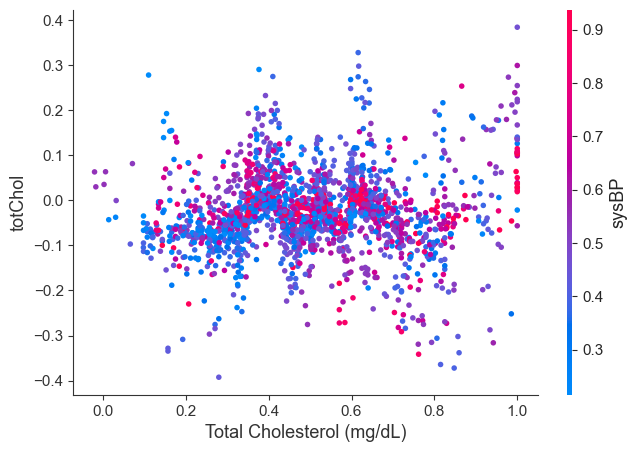

<Figure size 1000x600 with 0 Axes>

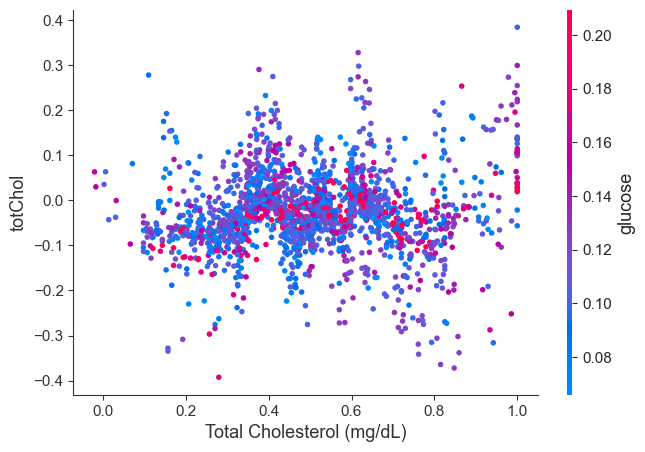

<Figure size 1000x600 with 0 Axes>

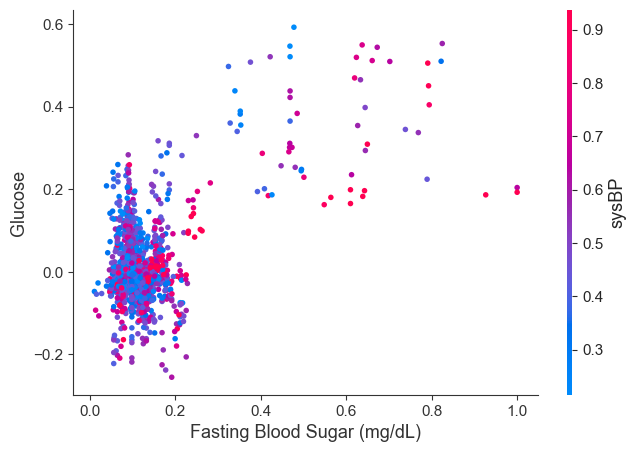

<Figure size 1000x600 with 0 Axes>

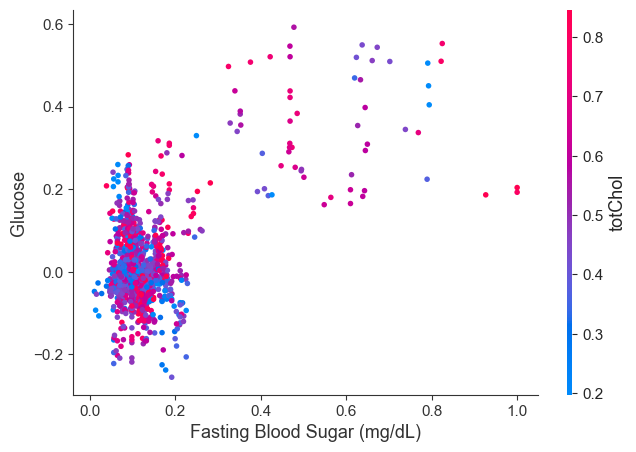

<Figure size 1000x600 with 0 Axes>

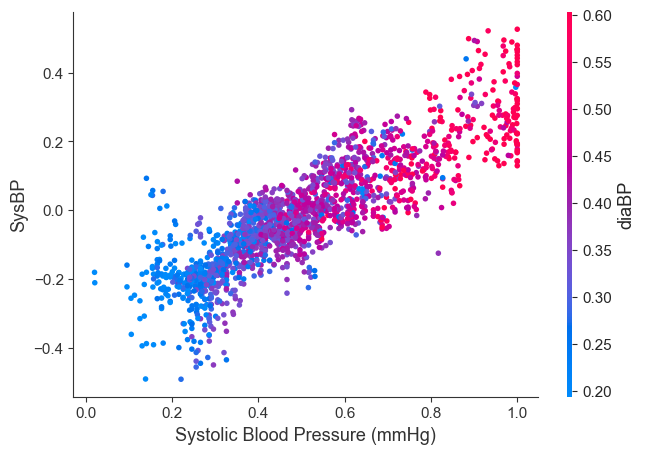

<Figure size 1000x600 with 0 Axes>

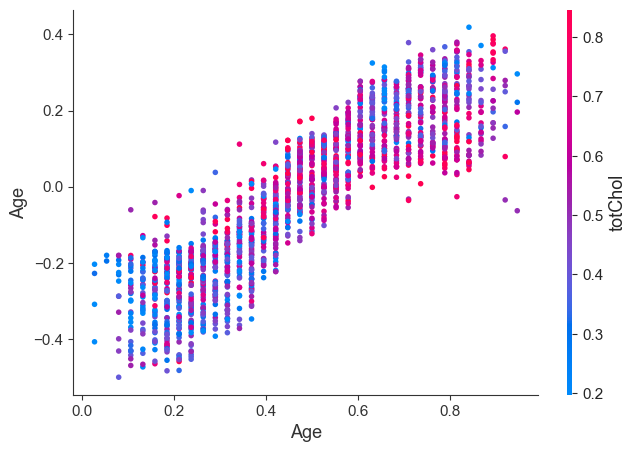

<Figure size 1000x600 with 0 Axes>

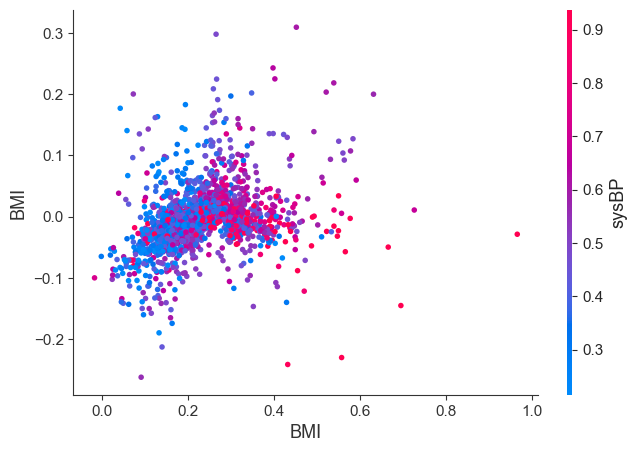

<Figure size 1000x600 with 0 Axes>

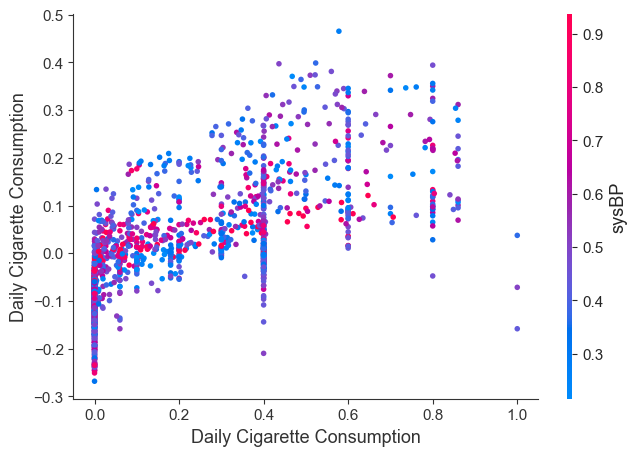

In [134]:
# Synergy effect analysis
plt.figure(figsize=(10, 6))
shap.dependence_plot("totChol", shap_values_trimmed, test_x_trimmed, interaction_index="sysBP", show=False)
plt.xlabel("Total Cholesterol (mg/dL)")
plt.ylabel("totChol")
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("totChol", shap_values_trimmed, test_x_trimmed, interaction_index="glucose", show=False)
plt.xlabel("Total Cholesterol (mg/dL)")
plt.ylabel("totChol")
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("glucose", shap_values_trimmed, test_x_trimmed, interaction_index="sysBP", show=False)
plt.xlabel("Fasting Blood Sugar (mg/dL)")
plt.ylabel("Glucose")
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("glucose", shap_values_trimmed, test_x_trimmed, interaction_index="totChol", show=False)
plt.xlabel("Fasting Blood Sugar (mg/dL)")
plt.ylabel("Glucose")
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("sysBP", shap_values_trimmed, test_x_trimmed, interaction_index="diaBP", show=False)
plt.xlabel("Systolic Blood Pressure (mmHg)")
plt.ylabel("SysBP")
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("age", shap_values_trimmed, test_x_trimmed, interaction_index="totChol", show=False)
plt.xlabel("Age")
plt.ylabel("Age")
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("BMI", shap_values_trimmed, test_x_trimmed, interaction_index="sysBP", show=False)
plt.xlabel("BMI")
plt.ylabel("BMI")
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("cigsPerDay", shap_values_trimmed, test_x_trimmed, interaction_index="sysBP", show=False)
plt.xlabel("Daily Cigarette Consumption")
plt.ylabel("Daily Cigarette Consumption")
plt.show()

In [135]:
# Risk surge analysis of feature combinations
min_val = 0
max_val = 1

min_orig_glucose = scaler.data_min_[features.index('glucose')]
max_orig_glucose = scaler.data_max_[features.index('glucose')]
min_orig_totChol = scaler.data_min_[features.index('totChol')]
max_orig_totChol = scaler.data_max_[features.index('totChol')]
min_orig_sysBP = scaler.data_min_[features.index('sysBP')]
max_orig_sysBP = scaler.data_max_[features.index('sysBP')]

def inverse_minmax(value, min_orig, max_orig):
    return value * (max_orig - min_orig) + min_orig

glucose_orig = inverse_minmax(test_x_trimmed['glucose'], min_orig_glucose, max_orig_glucose)
totChol_orig = inverse_minmax(test_x_trimmed['totChol'], min_orig_totChol, max_orig_totChol)
sysBP_orig = inverse_minmax(test_x_trimmed['sysBP'], min_orig_sysBP, max_orig_sysBP)

high_risk_mask = (glucose_orig > 126) & (totChol_orig > 240) & (sysBP_orig > 130)
high_risk_indices = high_risk_mask[high_risk_mask].index

find 31
sample 5:
- sysBP: 172.0629
- age: 59.0000
- totChol: 265.8524
- diaBP: 111.7885
- glucose: 234.2650
- cigsPerDay: 0.0000
- prevalentHyp: 1.0000
- BPMeds: 0.5738
- BMI: 31.1280
- diabetes: 1.0000
sample 42:
- sysBP: 145.2333
- age: 58.0000
- totChol: 286.6111
- diaBP: 72.9180
- glucose: 205.9806
- cigsPerDay: 0.0000
- prevalentHyp: 1.0000
- BPMeds: 0.0000
- BMI: 26.4071
- diabetes: 1.0000
sample 137:
- sysBP: 183.2500
- age: 61.0000
- totChol: 265.0000
- diaBP: 125.0000
- glucose: 256.0000
- cigsPerDay: 0.0000
- prevalentHyp: 1.0000
- BPMeds: 1.0000
- BMI: 29.5000
- diabetes: 1.0000
sample 141:
- sysBP: 183.2500
- age: 57.0000
- totChol: 283.2189
- diaBP: 111.9299
- glucose: 239.7614
- cigsPerDay: 0.0000
- prevalentHyp: 1.0000
- BPMeds: 1.0000
- BMI: 26.3355
- diabetes: 1.0000
sample 153:
- sysBP: 147.5457
- age: 64.0000
- totChol: 322.0128
- diaBP: 82.9563
- glucose: 394.0000
- cigsPerDay: 0.0000
- prevalentHyp: 0.0000
- BPMeds: 0.5578
- BMI: 23.1333
- diabetes: 1.0000
sample 

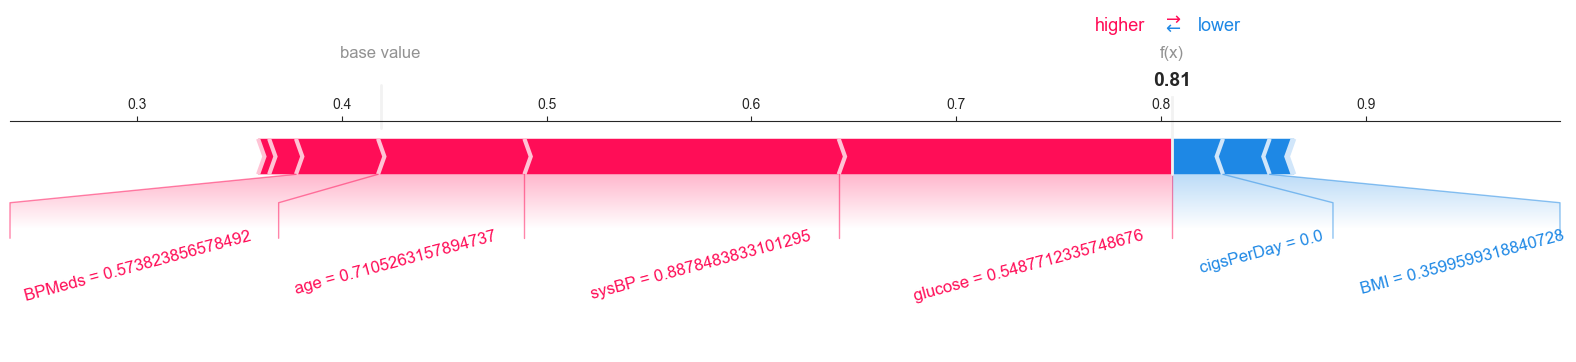

<Figure size 640x480 with 0 Axes>

In [136]:
if len(high_risk_indices) > 0:
    print(f"find {len(high_risk_indices)}")

    valid_indices = [idx for idx in high_risk_indices if idx < shap_values_stacking.shape[0]]

    if len(valid_indices) > 0:
        high_risk_explanations = shap.Explanation(
            values=shap_values_stacking[valid_indices],
            base_values=explainer_stacking.expected_value,
            data=test_x_trimmed.loc[valid_indices].values,
            feature_names=features
        )

        def inverse_minmax(value, min_orig, max_orig):
            return value * (max_orig - min_orig) + min_orig

        for i, idx in enumerate(valid_indices):
            sample = test_x_trimmed.loc[idx]
            original_values = {}

            for feature in features:
                min_orig = scaler.data_min_[features.index(feature)]
                max_orig = scaler.data_max_[features.index(feature)]
                original_values[feature] = inverse_minmax(sample[feature], min_orig, max_orig)

            print(f"sample {idx}:")
            for feature, value in original_values.items():
                print(f"- {feature}: {value:.4f}")

        sample_explanation = high_risk_explanations[0]
        print(f"\nSHAP Base Value: {sample_explanation.base_values}")

        pred_value = sample_explanation.base_values + sample_explanation.values.sum()
        print(f"Model predicted value: {pred_value}")

        positive_shap = {}
        negative_shap = {}

        for i, value in enumerate(sample_explanation.values):
            feature_name = features[i]
            feature_value = sample_explanation.data[i]

            if value > 0:
                positive_shap[feature_name] = {
                    'SHAP Value': value,
                    'feature Value': feature_value
                }
            elif value < 0:
                negative_shap[feature_name] = {
                    'SHAP Value': value,
                    'feature Value': feature_value
                }


        sorted_positive_shap = sorted(positive_shap.items(),
                                      key=lambda x: abs(x[1]['SHAP Value']),
                                      reverse=True)

        sorted_negative_shap = sorted(negative_shap.items(),
                                      key=lambda x: abs(x[1]['SHAP Value']),
                                      reverse=True)

        print("\n Positive contribution:")
        for feature, info in sorted_positive_shap:
            print(f"- {feature}: SHAP Value = {info['SHAP Value']:.4f}, feature Value = {info['feature Value']}")

        print("\n Negative contribution :")
        for feature, info in sorted_negative_shap:
            print(f"- {feature}: SHAP Value = {info['SHAP Value']:.4f}, feature Value = {info['feature Value']}")

        shap.plots.force(
            sample_explanation.base_values,
            sample_explanation.values,
            sample_explanation.data,
            feature_names=features,
            matplotlib=True,
            text_rotation=15
        )
        plt.tight_layout()
        plt.show()
else:
    print("No high-risk samples that met the conditions were found")

In [105]:
from itertools import product

try:
    gbc_model = joblib.load('gbc_model.pkl')
    rf_model = joblib.load('rf_model.pkl')
    xgb_model = joblib.load('xgb_model.pkl')
except FileNotFoundError:
    exit(1)
except Exception as e:
    exit(1)

weight_values = np.arange(0.1, 1.0, 0.1)
best_auc = 0
best_weights = None

for w1, w2, w3 in product(weight_values, repeat=3):
    if np.isclose(w1 + w2 + w3, 1.0):
        weights = [w1, w2, w3]

        voting_model_weighted = VotingClassifier(
            estimators=[('gbc', gbc_model), ('xgb', xgb_model), ('rf', rf_model)],
            voting='soft',
            weights=weights
        )
        voting_model_weighted.fit(train_x, train_y)

        y_pred_proba = voting_model_weighted.predict_proba(test_x)[:, 1]
        auc_score = roc_auc_score(test_y, y_pred_proba)

        if auc_score > best_auc:
            best_auc = auc_score
            best_weights = weights

print(f"Best Weights: {best_weights}")
print(f"Best AUC: {best_auc:.4f}")

voting_model_weighted = VotingClassifier(
    estimators=[('gbc', gbc_model), ('xgb', xgb_model), ('rf', rf_model)],
    voting='soft',
    weights=best_weights
)

voting_model_weighted.fit(train_x, train_y)

y_pred = voting_model_weighted.predict(test_x)
y_pred_proba = voting_model_weighted.predict_proba(test_x)[:, 1]
auc_score = roc_auc_score(test_y, y_pred_proba)
print(f"AUC: {auc_score:.4f}")

conf_matrix = confusion_matrix(test_y, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)

print("confussion matrix")
print(conf_matrix)

accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy of weighted voting: {accuracy:.4f}")
report = classification_report(test_y, y_pred, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_result = report['weighted avg']['f1-score']
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_result:.4f}")
print(f"Specificity (Sp): {Sp:.4f}")
print(f"Sensitivity (Sn): {Sn:.4f}")
print(f"Positive Predictive Value (PPV): {PPV:.4f}")
print(f"Negative Predictive Value (NPV): {NPV:.4f}")

joblib.dump(voting_model_weighted, 'voting_model_weighted.pkl')

Best Weights: [0.8, 0.1, 0.1]
Best AUC: 0.9791
AUC: 0.9791
confussion matrix
[[865  54]
 [ 55 920]]
Accuracy of weighted voting: 0.9424
Precision: 0.9425
Recall: 0.9424
F1-score: 0.9425
Specificity (Sp): 0.9412
Sensitivity (Sn): 0.9436
Positive Predictive Value (PPV): 0.9446
Negative Predictive Value (NPV): 0.9402


['voting_model_weighted.pkl']

In [138]:
background = shap.sample(test_x,100)

explainer = shap.KernelExplainer(voting_model_weighted.predict_proba, background)
shap_values = explainer.shap_values(test_x, nsamples=100)
print(shap_values.shape)

  0%|          | 0/1894 [00:00<?, ?it/s]

(1894, 10, 2)



=== Generalization Ability Test Report ===
The number of test set samples: 200
Proportion of positive samples: 55.0%

Performance index (with 95% confidence interval):
Accuracy                      : 0.8850 [0.8397, 0.9200]
ROC AUC                       : 0.9288 [0.8966, 0.9587]
F1 Score                      : 0.9004 [0.8574, 0.9309]
Precision                     : 0.8595 [0.7934, 0.9071]
Recall                        : 0.9455 [0.8915, 0.9771]
Specificity (Sp)              : 0.8111 [0.7104, 0.8854]
Sensitivity (Sn)              : 0.9455 [0.8915, 0.9771]
Positive Predictive Value (PPV): 0.8595 [0.7934, 0.9071]
Negative Predictive Value (NPV): 0.9241 [0.8702, 0.9705]
Net Reclassification Index (NRI): 0.5990 [0.4936, 0.7382]
Integrated Discrimination Improvement (IDI): 0.3505 [0.2951, 0.4037]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        90
           1       0.86      0.95      0.90       110

    accura

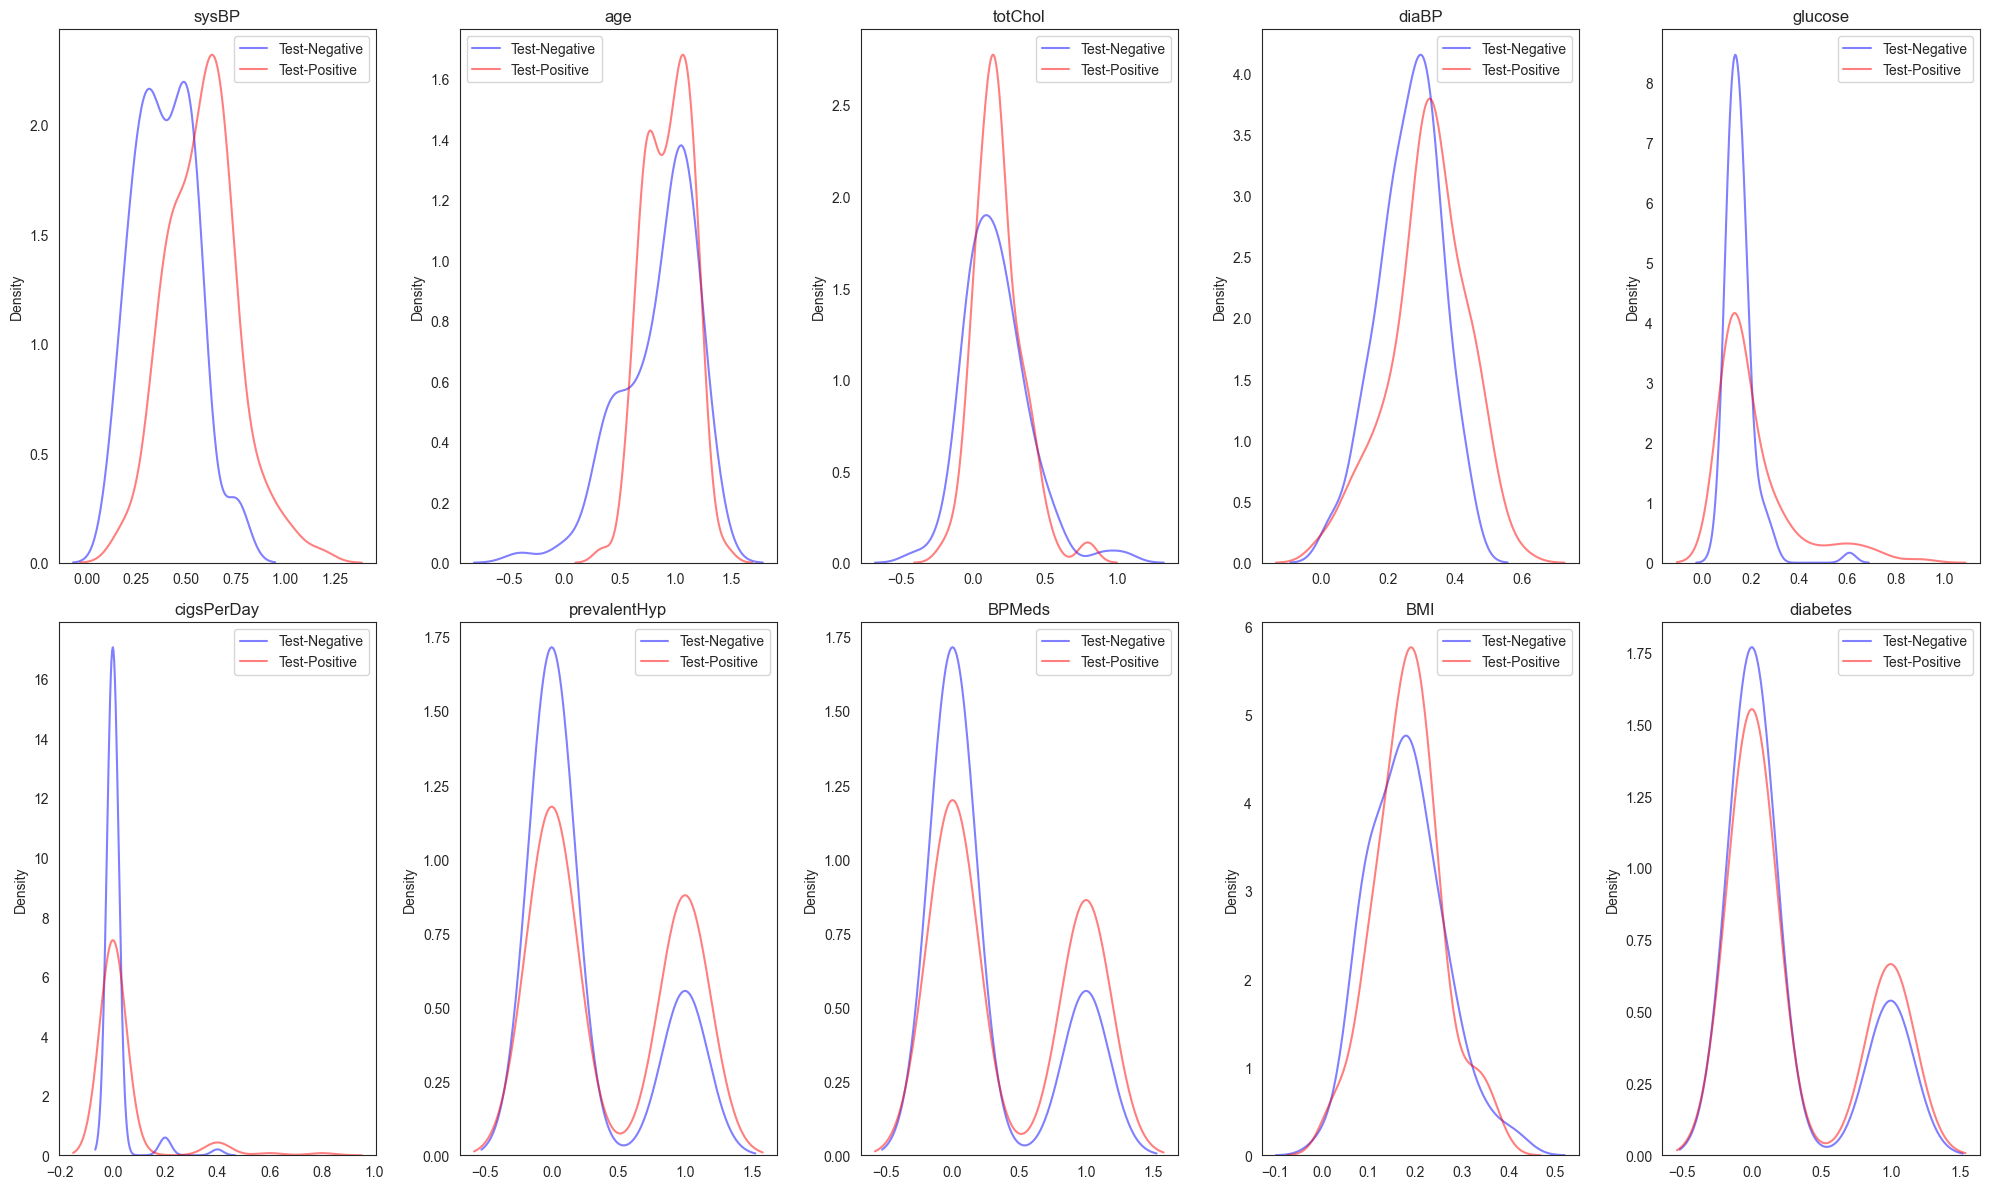

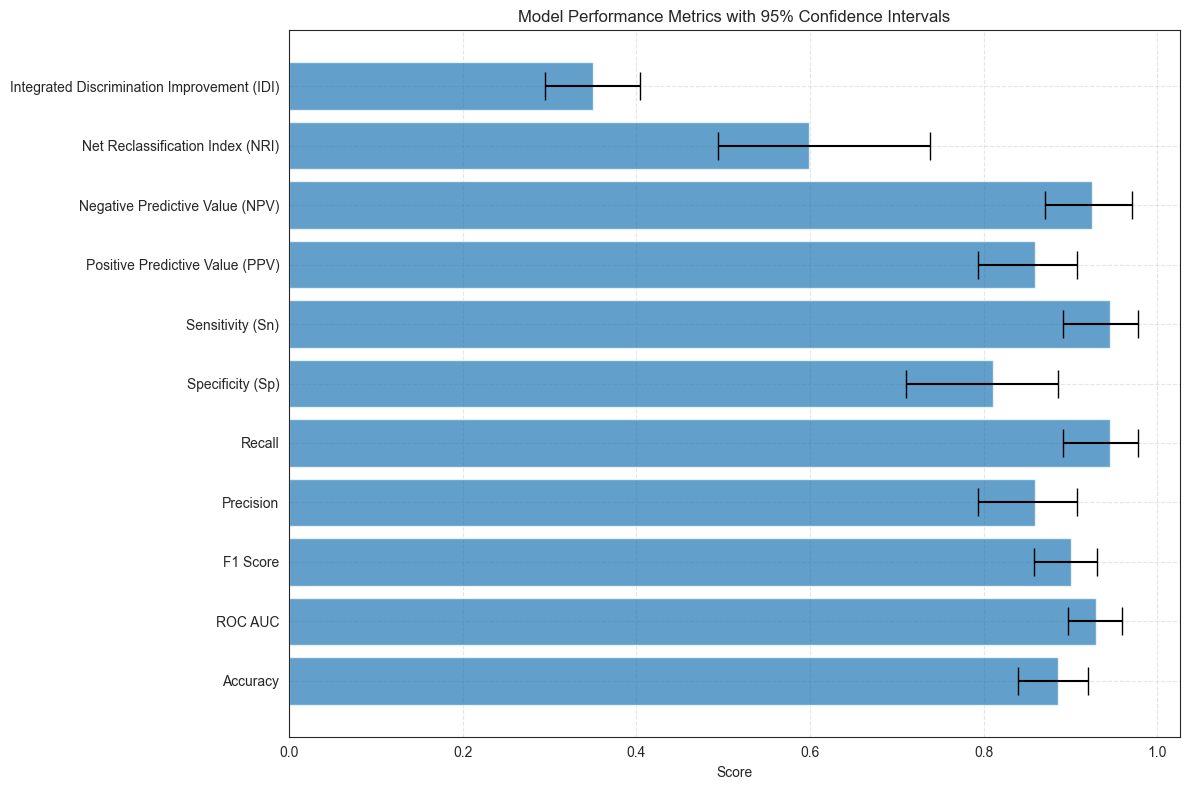

In [235]:
def preprocess_test_data(test_df):
    test_processed = test_df.rename(columns={
        'sysBP': 'sysBP',
        'age': 'age',
        'diaBP': 'diaBP',
        'glucose': 'glucose',
        'totChol': 'totChol',
        'cigsPerDay': 'cigsPerDay',
        'prevalentHyp': 'prevalentHyp',
        'diabetes': 'diabetes',
        'CHD': 'CHD',
        'BMI': 'BMI',
        'BPMeds': 'BPMeds'
    })

    required_features = ['sysBP', 'age', 'totChol', 'diaBP', 'glucose', 'cigsPerDay', 'prevalentHyp', 'BPMeds', 'BMI', 'diabetes']
    for feature in required_features:
        if feature not in test_processed.columns:
            test_processed[feature] = 0

    extra_features = [col for col in test_processed.columns if col not in required_features and col != 'CHD']
    test_processed = test_processed.drop(extra_features, axis=1)

    return test_processed[required_features + ['CHD']]

test_df = pd.read_excel('../data/local_data.xlsx')
test_processed = preprocess_test_data(test_df)
scaler = joblib.load('minmax_scaler.pkl')
X_test = test_processed.drop('CHD', axis=1)
y_test = test_processed['CHD']
X_test_scaled = scaler.transform(X_test)

best_model = joblib.load('stacking_classifier.pkl')
baseline_model = joblib.load('rf_model.pkl')

y_proba_new = best_model.predict_proba(X_test_scaled)[:, 1]
y_proba_old = baseline_model.predict_proba(X_test_scaled)[:, 1]
y_pred = best_model.predict(X_test_scaled)

def calculate_nri(y_true, y_proba_new, y_proba_old, thresholds=[0.2, 0.5]):
    nri = 0
    for t in thresholds:
        risk_old = (y_proba_old >= t).astype(int)
        risk_new = (y_proba_new >= t).astype(int)

        tp_improved = np.sum((y_true == 1) & (risk_new > risk_old))
        tp_worsened = np.sum((y_true == 1) & (risk_new < risk_old))

        tn_improved = np.sum((y_true == 0) & (risk_new < risk_old))
        tn_worsened = np.sum((y_true == 0) & (risk_new > risk_old))

        nri_tp = (tp_improved - tp_worsened) / np.sum(y_true == 1)
        nri_tn = (tn_improved - tn_worsened) / np.sum(y_true == 0)
        nri += (nri_tp + nri_tn)
    return nri

def calculate_idi(y_true, y_proba_new, y_proba_old):
    idi_tp = np.mean(y_proba_new[y_true == 1]) - np.mean(y_proba_old[y_true == 1])
    idi_tn = np.mean(y_proba_old[y_true == 0]) - np.mean(y_proba_new[y_true == 0])
    return idi_tp + idi_tn

n_bootstraps = 100
bootstrap_metrics = {
    'Accuracy': [],
    'ROC AUC': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'Specificity (Sp)': [],
    'Sensitivity (Sn)': [],
    'Positive Predictive Value (PPV)': [],
    'Negative Predictive Value (NPV)': [],
    'Net Reclassification Index (NRI)': [],
    'Integrated Discrimination Improvement (IDI)': []
}

risk_thresholds = [0.2, 0.5]

for i in range(n_bootstraps):
    indices = resample(range(len(X_test_scaled)), replace=True)
    X_boot = X_test_scaled[indices]
    y_boot = y_test.iloc[indices]

    y_boot_proba_new = best_model.predict_proba(X_boot)[:, 1]
    y_boot_proba_old = baseline_model.predict_proba(X_boot)[:, 1]
    y_boot_pred = best_model.predict(X_boot)

    acc = accuracy_score(y_boot, y_boot_pred)
    roc = roc_auc_score(y_boot, y_boot_proba_new)
    f1 = f1_score(y_boot, y_boot_pred)
    prec = precision_score(y_boot, y_boot_pred)
    rec = recall_score(y_boot, y_boot_pred)

    conf_matrix = confusion_matrix(y_boot, y_boot_pred)
    if conf_matrix.shape == (2, 2):
        TN, FP, FN, TP = conf_matrix.ravel()
        Sp = TN / (TN + FP) if (TN + FP) > 0 else 0
        Sn = TP / (TP + FN) if (TP + FN) > 0 else 0
        PPV = TP / (TP + FP) if (TP + FP) > 0 else 0
        NPV = TN / (TN + FN) if (TN + FN) > 0 else 0
    else:
        Sp, Sn, PPV, NPV = 0, 0, 0, 0

    nri_boot = calculate_nri(y_boot, y_boot_proba_new, y_boot_proba_old, thresholds=risk_thresholds)
    idi_boot = calculate_idi(y_boot, y_boot_proba_new, y_boot_proba_old)

    bootstrap_metrics['Accuracy'].append(acc)
    bootstrap_metrics['ROC AUC'].append(roc)
    bootstrap_metrics['F1 Score'].append(f1)
    bootstrap_metrics['Precision'].append(prec)
    bootstrap_metrics['Recall'].append(rec)
    bootstrap_metrics['Specificity (Sp)'].append(Sp)
    bootstrap_metrics['Sensitivity (Sn)'].append(Sn)
    bootstrap_metrics['Positive Predictive Value (PPV)'].append(PPV)
    bootstrap_metrics['Negative Predictive Value (NPV)'].append(NPV)
    bootstrap_metrics['Net Reclassification Index (NRI)'].append(nri_boot)
    bootstrap_metrics['Integrated Discrimination Improvement (IDI)'].append(idi_boot)

conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
Sp = TN / (TN + FP)
Sn = TP / (TP + FN)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)
nri = calculate_nri(y_test, y_proba_new, y_proba_old, thresholds=risk_thresholds)
idi = calculate_idi(y_test, y_proba_new, y_proba_old)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba_new),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'Specificity (Sp)': Sp,
    'Sensitivity (Sn)': Sn,
    'Positive Predictive Value (PPV)': PPV,
    'Negative Predictive Value (NPV)': NPV,
    'Net Reclassification Index (NRI)': nri,
    'Integrated Discrimination Improvement (IDI)': idi
}

confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100
confidence_intervals = {}

for metric_name, values in bootstrap_metrics.items():
    lower_bound = np.percentile(values, lower_percentile)
    upper_bound = np.percentile(values, upper_percentile)
    confidence_intervals[metric_name] = (lower_bound, upper_bound)

print("\n=== Generalization Ability Test Report ===")
print(f"The number of test set samples: {len(test_processed)}")
print(f"Proportion of positive samples: {y_test.mean():.1%}")
print("\nPerformance index (with 95% confidence interval):")
for k in metrics.keys():
    mean_val = metrics[k]
    lower, upper = confidence_intervals[k]
    print(f"{k:<30}: {mean_val:.4f} [{lower:.4f}, {upper:.4f}]")

print("\nClassification report:")
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(2, 5, figsize=(20, 12))
for i, col in enumerate(X_test.columns):
    sns.kdeplot(X_test_scaled[:, i][y_test == 0], ax=ax[i // 5, i % 5], label='Test-Negative', color='blue', alpha=0.5)
    sns.kdeplot(X_test_scaled[:, i][y_test == 1], ax=ax[i // 5, i % 5], label='Test-Positive', color='red', alpha=0.5)
    ax[i // 5, i % 5].set_title(col)
    ax[i // 5, i % 5].legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
y_pos = np.arange(len(metrics))
means = list(metrics.values())
lower_errors = [means[i] - confidence_intervals[k][0] for i, k in enumerate(metrics.keys())]
upper_errors = [confidence_intervals[k][1] - means[i] for i, k in enumerate(metrics.keys())]
errors = [lower_errors, upper_errors]

plt.barh(y_pos, means, xerr=errors, align='center', alpha=0.7, ecolor='black', capsize=10)
plt.yticks(y_pos, list(metrics.keys()))
plt.xlabel('Score')
plt.title('Model Performance Metrics with 95% Confidence Intervals')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

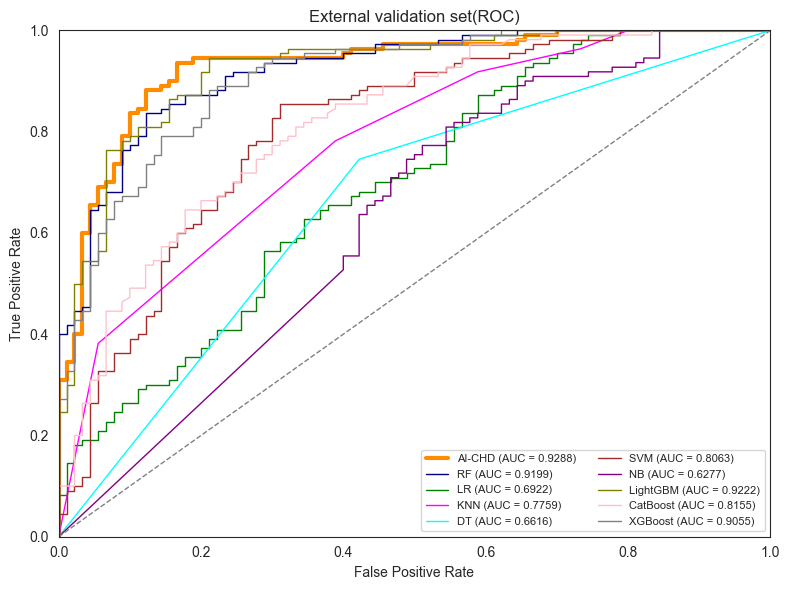

In [288]:
test_df = pd.read_excel('../data/local_data.xlsx')
test_processed = preprocess_test_data(test_df)
scaler = joblib.load('minmax_scaler.pkl')

X_test = test_processed.drop('CHD', axis=1)
y_test = test_processed['CHD']
X_test_scaled = scaler.transform(X_test)

best_model = joblib.load('stacking_classifier.pkl')
model_lr = joblib.load('lr_model.pkl')
model_nb = joblib.load('nb_model.pkl')
model_svm = joblib.load('svm_model.pkl')
model_dt = joblib.load('dt_model.pkl')
model_knn = joblib.load('knn_model.pkl')
model_lgbm = joblib.load('lgbm_model.pkl')
model_voting = joblib.load('voting_model_weighted.pkl')
model_xgb = joblib.load('xgb_model.pkl')
model_catboost = joblib.load('catboost_model.pkl')

y_proba_new = best_model.predict_proba(X_test_scaled)[:, 1]
y_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
y_proba_nb = model_nb.predict_proba(X_test_scaled)[:, 1]
y_proba_svm = model_svm.predict_proba(X_test_scaled)[:, 1]
y_proba_dt = model_dt.predict_proba(X_test_scaled)[:, 1]
y_proba_knn = model_knn.predict_proba(X_test_scaled)[:, 1]
y_proba_voting = model_voting.predict_proba(X_test_scaled)[:, 1]
y_proba_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]
y_proba_catboost = model_catboost.predict_proba(X_test_scaled)[:, 1]

y_pred = best_model.predict(X_test_scaled)

fpr_new, tpr_new, _ = roc_curve(y_test, y_proba_new)
auc_new = roc_auc_score(y_test, y_proba_new)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_old)
auc_rf = roc_auc_score(y_test, y_proba_old)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
auc_svm = roc_auc_score(y_test, y_proba_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
auc_knn = roc_auc_score(y_test, y_proba_knn)

fpr_voting, tpr_voting, _ = roc_curve(y_test, y_proba_voting)
auc_voting = roc_auc_score(y_test, y_proba_voting)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_proba_catboost)
auc_catboost = roc_auc_score(y_test, y_proba_catboost)

sns.set_style('white')
plt.figure(figsize=(8, 6))

plt.plot(fpr_new, tpr_new, lw=3, color='darkorange',label=f'AI-CHD (AUC = {auc_new:.4f})')
plt.plot(fpr_rf, tpr_rf, lw=1, color='navy',label=f'RF (AUC = {auc_rf:.4f})')
plt.plot(fpr_lr, tpr_lr, lw=1, color='green',label=f'LR (AUC = {auc_lr:.4f})')
plt.plot(fpr_knn, tpr_knn, lw=1, color='magenta',label=f'KNN (AUC = {auc_knn:.4f})')
plt.plot(fpr_dt, tpr_dt, lw=1, color='cyan',label=f'DT (AUC = {auc_dt:.4f})')
plt.plot(fpr_svm, tpr_svm, lw=1, color='brown',label=f'SVM (AUC = {auc_svm:.4f})')
plt.plot(fpr_nb, tpr_nb, lw=1, color='purple',label=f'NB (AUC = {auc_nb:.4f})')
plt.plot(fpr_voting, tpr_voting, lw=1, color='olive',label=f'LightGBM (AUC = {auc_voting:.4f})')
plt.plot(fpr_catboost, tpr_catboost, lw=1, color='pink',label=f'CatBoost (AUC = {auc_catboost:.4f})')
plt.plot(fpr_xgb, tpr_xgb, lw=1, color='gray',label=f'XGBoost (AUC = {auc_xgb:.4f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('External validation set(ROC)', fontsize=12)
plt.legend(loc='lower right', fontsize=8, ncol=2)
plt.grid(False)

auc_values = {
    'model': ['AI-CHD', 'RF','XGBoost', 'LightGBM', 'CatBoost', 'LR', 'SVM', 'KNN', 'NB', 'DT'],
    'AUC': [auc_new, auc_rf, auc_xgb, auc_catboost, auc_voting, auc_lr, auc_svm, auc_knn, auc_nb, auc_dt]
}
auc_df = pd.DataFrame(auc_values).sort_values('AUC', ascending=False)

plt.tight_layout()
plt.show()

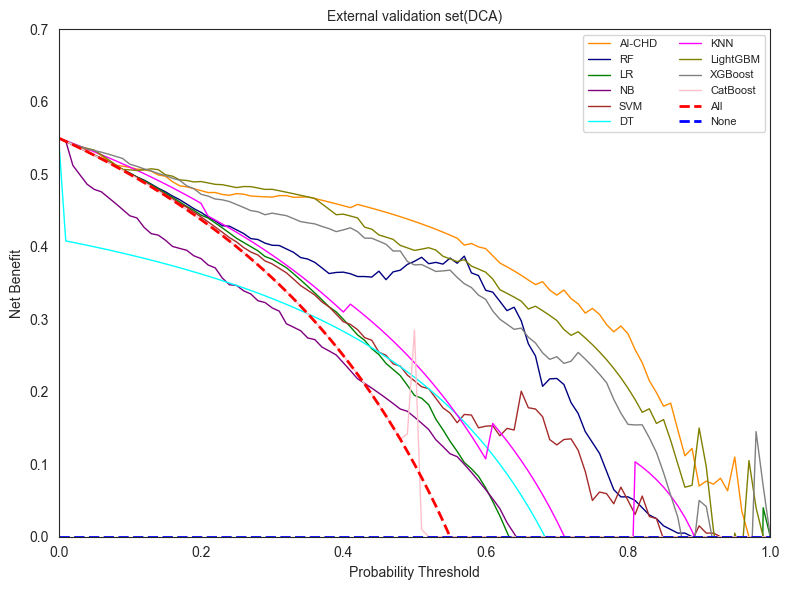

In [277]:
test_df = pd.read_excel('../data/local_data.xlsx')
test_processed = preprocess_test_data(test_df)
scaler = joblib.load('minmax_scaler.pkl')
X_test = test_processed.drop('CHD', axis=1)
y_test = test_processed['CHD']
X_test_scaled = scaler.transform(X_test)

best_model = joblib.load('stacking_classifier.pkl')
baseline_model_rf = joblib.load('rf_model.pkl')
baseline_model_lr = joblib.load('lr_model.pkl')
baseline_model_nb = joblib.load('nb_model.pkl')
baseline_model_svm = joblib.load('svm_model.pkl')
baseline_model_dt = joblib.load('dt_model.pkl')
baseline_model_knn = joblib.load('knn_model.pkl')
baseline_model_voting = joblib.load('voting_model_weighted.pkl')
baseline_model_xgb = joblib.load('xgb_model.pkl')
baseline_model_catboost = joblib.load('catboost_model.pkl')

y_proba_new = best_model.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = baseline_model_rf.predict_proba(X_test_scaled)[:, 1]
y_proba_lr = baseline_model_lr.predict_proba(X_test_scaled)[:, 1]
y_proba_nb = baseline_model_nb.predict_proba(X_test_scaled)[:, 1]
y_proba_svm = baseline_model_svm.predict_proba(X_test_scaled)[:, 1]
y_proba_dt = baseline_model_dt.predict_proba(X_test_scaled)[:, 1]
y_proba_knn = baseline_model_knn.predict_proba(X_test_scaled)[:, 1]
y_proba_voting = baseline_model_voting.predict_proba(X_test_scaled)[:, 1]
y_proba_xgb = baseline_model_xgb.predict_proba(X_test_scaled)[:, 1]
y_proba_catboost = baseline_model_catboost.predict_proba(X_test_scaled)[:, 1]

def decision_curve_analysis(y_true, y_proba, thresholds=None, label='Model'):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 101)

    net_benefits = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() if confusion_matrix(y_true, y_pred).size == 4 else (0, 0, 0, 0)
        n = len(y_true)
        benefit = (tp/n) - (fp/n) * (t / (1 - t)) if (1 - t) != 0 else 0
        net_benefits.append(benefit)

    p = np.mean(y_true)
    all_positive = [p - (1-p) * (t/(1-t)) if t < 1 else 0 for t in thresholds]
    all_negative = [0] * len(thresholds)

    return thresholds, net_benefits, all_positive, all_negative

plt.figure(figsize=(8, 6))
thresholds, net_benefits_new, all_positive, all_negative = decision_curve_analysis(y_test, y_proba_new, label='Stacking Model')
_, net_benefits_rf, _, _ = decision_curve_analysis(y_test, y_proba_rf, label='RF Model')
_, net_benefits_lr, _, _ = decision_curve_analysis(y_test, y_proba_lr, label='LR Model')
_, net_benefits_nb, _, _ = decision_curve_analysis(y_test, y_proba_nb, label='NB Model')
_, net_benefits_svm, _, _ = decision_curve_analysis(y_test, y_proba_svm, label='SVM Model')
_, net_benefits_dt, _, _ = decision_curve_analysis(y_test, y_proba_dt, label='DT Model')
_, net_benefits_knn, _, _ = decision_curve_analysis(y_test, y_proba_knn, label='KNN Model')
_, net_benefits_voting, _, _ = decision_curve_analysis(y_test, y_proba_voting, label='voting')
_, net_benefits_xgb, _, _ = decision_curve_analysis(y_test, y_proba_xgb, label='XGB Model')
_, net_benefits_catboost, _, _ = decision_curve_analysis(y_test, y_proba_catboost, label='CatBoost Model')

plt.plot(thresholds, net_benefits_new, color='darkorange', lw=1, label='AI-CHD')
plt.plot(thresholds, net_benefits_rf, color='navy', lw=1, label='RF')
plt.plot(thresholds, net_benefits_lr, color='green', lw=1, label='LR')
plt.plot(thresholds, net_benefits_nb, color='purple', lw=1, label='NB')
plt.plot(thresholds, net_benefits_svm, color='brown', lw=1, label='SVM')
plt.plot(thresholds, net_benefits_dt, color='cyan', lw=1, label='DT')
plt.plot(thresholds, net_benefits_knn, color='magenta', lw=1, label='KNN')
plt.plot(thresholds, net_benefits_voting, color='olive', lw=1, label='LightGBM')
plt.plot(thresholds, net_benefits_xgb, color='gray', lw=1, label='XGBoost')
plt.plot(thresholds, net_benefits_catboost, color='pink', lw=1, label='CatBoost')

plt.plot(thresholds, all_positive, color='red', linestyle='--', lw=2, label='All')
plt.plot(thresholds, all_negative, color='blue', linestyle='--', lw=2, label='None')

plt.xlabel('Probability Threshold', fontsize=10)
plt.ylabel('Net Benefit', fontsize=10)
plt.title('External validation set(DCA)', fontsize=10)
plt.legend(loc='upper right', fontsize=8, ncol=2)
plt.xlim([0, 1])
plt.ylim([0, 0.7])
plt.tight_layout()
plt.show()